In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Set

In [2]:
def filter_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter by
    - Require IVF_before_hr_24_no_L_cutoff >= 0.25 (i.e., 250 ml of IVF in first 24 hrs)
    - Exclude isolated head injuries (i.e., Head AIS >= 3 and all other AIS <= 1)
    :param df: compiled patient dataframe
    :return: filtered patient dataframe
    """
    max_ais_col_name = 'MaxNonHeadAIS'
    df[max_ais_col_name] = df[['MaxHeadAIS', 'MaxChestAIS', 'MaxAbdAIS', 'MaxSpineAIS', 'MaxLEAIS', 'MaxUEAIS', 'MaxFaceAIS', 'MaxNeckAIS']].max(axis=1)
    filtered_data = df[((df['IVF_before_hr_24_no_L_cutoff'] > 0.25) | np.isclose(df['IVF_before_hr_24_no_L_cutoff'], 0.25)) & 
                        ((df['MaxHeadAIS'] < 3) | (df[max_ais_col_name] > 1))]
    df.drop(columns=[max_ais_col_name], inplace=True)
    return filtered_data

def load_patient_cohort_ids() -> Set[int]:
    # load 2012-2015 patient cohort ids
    compiled_patient_data_2012_2015 = pd.read_csv('<path_to_dataset>/2012-2015_compiled_patient_data_with_cohorts_no_L_required_new_IVF_EarlyLateBolus.csv')
    compiled_patient_data_2012_2015 = filter_data(compiled_patient_data_2012_2015)['StudyID']
    # load 2016-2019 patient cohort ids
    compiled_patient_data_2016_2019 = pd.read_csv('<path_to_dataset>/2016-2019_compiled_patient_data_with_cohorts_no_L_required_new_IVF_EarlyLateBolus.csv')
    compiled_patient_data_2016_2019['StudyID'] = compiled_patient_data_2016_2019['StudyID'].astype(int)
    compiled_patient_data_2016_2019 = filter_data(compiled_patient_data_2016_2019)['StudyID']
    # combine patient cohort ids
    study_ids = set(compiled_patient_data_2012_2015.tolist()).union(set(compiled_patient_data_2016_2019.tolist()))
    print(f'Number of patient cohort ids: {len(study_ids)} (2012-2015: {len(compiled_patient_data_2012_2015)}, 2016-2019: {len(compiled_patient_data_2016_2019)})')
    return study_ids

# Labs and Vitals

- Creatinine
- INR
- pH
- FiO2 and Corrected FiO2 (Dr. Beni wants us to use the corrected dfiles)
- RR
- MAP
- HR
- SBP
- DBP
- Temp
- UOP
- lactate
- PaO2
- PACO2
- SpO2
- HCO3

## Start with Creatinine

In [3]:
creatinine_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_Creatinine.csv')
creatinine_2012_2015_data.head()

,StudyID,AdmitDate,Observation,ObservationValue,Units,ObservationId,ObservationDtTm
0,16000,1/1/12,Creatinine,1.2,mg/dL,CRE,1/1/12 5:13
1,16000,1/1/12,Creatinine,0.77,mg/dL,CRE,1/1/12 6:35
2,16000,1/1/12,Creatinine,0.96,mg/dL,CRE,1/1/12 16:10
3,16000,1/1/12,Creatinine,0.86,mg/dL,CRE,1/2/12 6:30
4,16000,1/1/12,Creatinine,0.85,mg/dL,CRE,1/3/12 12:30


In [4]:
creatinine_2012_2015_data['ObservationValue'].unique()

array(['1.2', '0.77', '0.96', '0.86', '0.85', '0.93', '0.67', '0.56',
       '0.43', '0.6', '0.44', '0.5', '0.45', '0.53', '0.7', '1.4', '0.84',
       '0.9', '0.95', '0.71', '0.74', '0.69', '0.63', '0.59', '0.55',
       '0.49', '0.64', '1.07', '0.82', '0.61', '0.58', '0.46', '0.52',
       '0.41', '0.57', '1.76', '1.45', '1.42', '1.23', '1.17', '1.3',
       '1.38', '1.32', '0.76', '0.51', '1.08', '1.21', '1.02', '1.09',
       '0.78', '0.28', '1.03', '1.05', '0.88', '0.8', '0.68', '0.73',
       '0.66', '0.79', '0.65', '0.37', '0.42', '1.04', '0.99', '0.81',
       '0.98', '0.92', '1.06', '1', '1.16', '1.1', '1.14', '0.91', '0.89',
       '1.13', '1.11', '0.47', '0.75', '0.62', '1.18', '1.41', '1.64',
       '1.48', '1.37', '1.36', '2.01', '0.87', '0.83', '0.34', '1.25',
       '1.44', '1.26', '0.72', '0.54', '0.48', '1.82', '1.66', '1.62',
       '1.31', '0.97', '1.61', '0.26', '0.18', '1.28', '1.51', '1.53',
       '1.54', '0.23', '0.16', '0.4', '0.38', '1.15', '0.21', '2.08',
   

In [5]:
creatinine_2012_2015_data['ObservationValue'] = pd.to_numeric(creatinine_2012_2015_data['ObservationValue'], errors='coerce')

In [6]:
creatinine_2012_2015_data.dtypes

StudyID               int64
AdmitDate            object
Observation          object
ObservationValue    float64
Units                object
ObservationId        object
ObservationDtTm      object
dtype: object

In [7]:
creatinine_2012_2015_data['Units'].value_counts()

Units
mg/dL    73447
Name: count, dtype: int64

<Axes: >

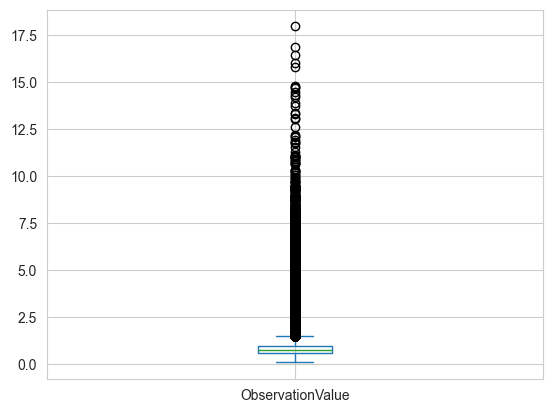

In [8]:
creatinine_2012_2015_data['ObservationValue'].plot.box()

In [9]:
creatinine_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_Creatinine.csv')
creatinine_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm
0,1,1/1/16 2:07,Creatinine,1,2:45:00 AM,0.84,1/1/16 2:45
1,1,1/1/16 2:07,Creatinine,1,2:00:00 PM,0.78,1/1/16 14:00
2,1,1/1/16 2:07,Creatinine,2,4:35:00 AM,0.68,1/2/16 4:35
3,1,1/1/16 2:07,Creatinine,3,7:49:00 AM,0.66,1/3/16 7:49
4,1,1/1/16 2:07,Creatinine,4,7:40:00 AM,0.66,1/4/16 7:40


In [10]:
creatinine_2016_2019_data.dtypes

StudyID               int64
AdmitDtTm            object
Observation          object
DAY                   int64
TIME                 object
ObservationValue    float64
ObservationDtTm      object
dtype: object

<Axes: >

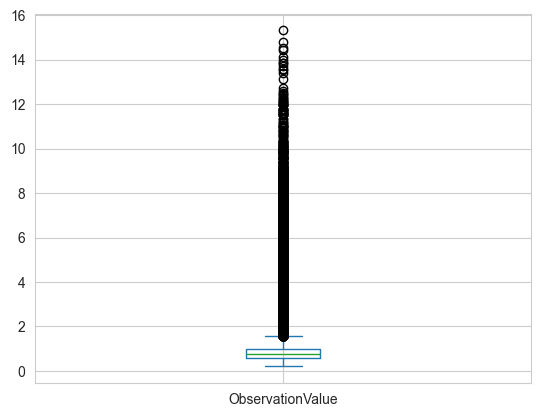

In [11]:
creatinine_2016_2019_data['ObservationValue'].plot.box()

count    166762.000000
mean          0.951796
std           0.897378
min           0.100000
25%           0.590000
50%           0.750000
75%           0.970000
max          17.950000
Name: ObservationValue, dtype: float64


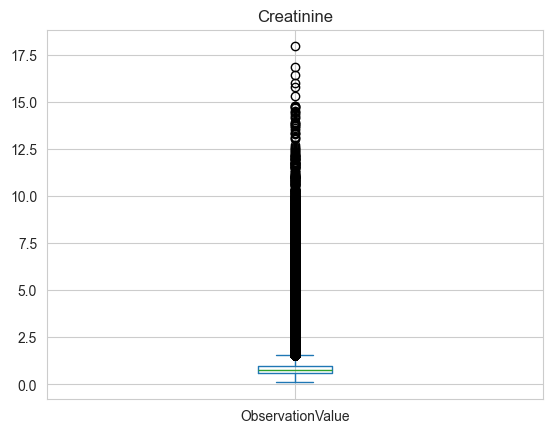

In [12]:
t = pd.concat([creatinine_2016_2019_data['ObservationValue'], creatinine_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('Creatinine')
del t

Creatine looks good. Units appear to be in mg/dL. The distributions are similar between 2012-2015 and 2016-2019.

## INR

In [13]:
inr_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_INR.csv')
inr_2012_2015_data.head()

,StudyID,Observation,ObservationValue,Units,ObservationId,ObservationDtTm
0,16000,Prothrombin INR,1.1,NaN,PROINR,1/1/12 5:13 AM
1,16000,Prothrombin INR,1.4,NaN,PROINR,1/1/12 6:35 AM
2,16000,Prothrombin INR,1.3,NaN,PROINR,1/1/12 10:40 AM
3,16001,Prothrombin INR,1.2,NaN,PROINR,1/1/12 4:08 AM
4,16001,Prothrombin INR,1.6,NaN,PROINR,1/1/12 5:42 AM


In [14]:
inr_2012_2015_data['ObservationValue'].unique()

array([ 1.1,  1.4,  1.3,  1.2,  1.6,  1.7,  1. ,  1.5,  3. ,  2.4,  2. ,
        1.8,  2.2,  1.9,  2.1,  2.8,  3.1,  0.9,  2.9,  2.3,  2.6,  4.2,
        2.5,  3.2, 10.7,  8. ,  2.7,  3.5,  4.8,  4.4,  5.5,  3.9,  3.8,
        4.7,  6.4,  5.8,  9.7,  3.6,  0.8,  5.9,  3.4,  4.5,  5.1,  5.3,
        7. ,  6.2,  6.1,  3.3,  4.1,  3.7,  4.9,  7.2, 14.6,  4.6,  0.7,
        9.4,  4. ,  6.6,  7.3,  4.3, 10.5,  8.2,  9.6, 11.8,  0.3,  5. ,
        5.4,  7.1,  7.4])

In [15]:
inr_2012_2015_data.dtypes

StudyID               int64
Observation          object
ObservationValue    float64
Units               float64
ObservationId        object
ObservationDtTm      object
dtype: object

In [16]:
inr_2012_2015_data['Units'].value_counts()

Series([], Name: count, dtype: int64)

<Axes: >

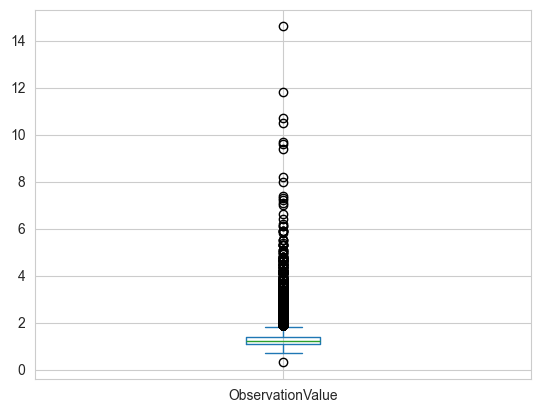

In [17]:
inr_2012_2015_data['ObservationValue'].plot.box()

In [18]:
inr_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_INR.csv')
inr_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm,Unnamed: 7,Unnamed: 8
0,1,1/1/16 2:07 AM,Prothrombin INR,1,2:45:00 AM,1.0,1/1/16 2:45 AM,NaN,NaN
1,1,1/1/16 2:07 AM,Prothrombin INR,1,2:00:00 PM,1.1,1/1/16 2:00 PM,NaN,NaN
2,1,1/1/16 2:07 AM,Prothrombin INR,2,4:35:00 AM,1.1,1/2/16 4:35 AM,NaN,NaN
3,2,1/1/16 10:13 PM,Prothrombin INR,1,11:51:00 PM,1.1,1/1/16 11:51 PM,NaN,NaN
4,2,1/1/16 10:13 PM,Prothrombin INR,14,9:01:00 PM,1.0,1/14/16 9:01 PM,NaN,NaN


In [19]:
inr_2016_2019_data.dtypes

StudyID               int64
AdmitDtTm            object
Observation          object
DAY                   int64
TIME                 object
ObservationValue    float64
ObservationDtTm      object
Unnamed: 7          float64
Unnamed: 8          float64
dtype: object

<Axes: >

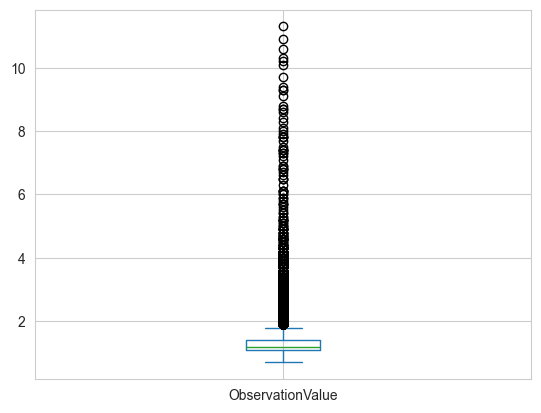

In [20]:
inr_2016_2019_data['ObservationValue'].plot.box()

count    74617.000000
mean         1.337132
std          0.472514
min          0.300000
25%          1.100000
50%          1.200000
75%          1.400000
max         14.600000
Name: ObservationValue, dtype: float64


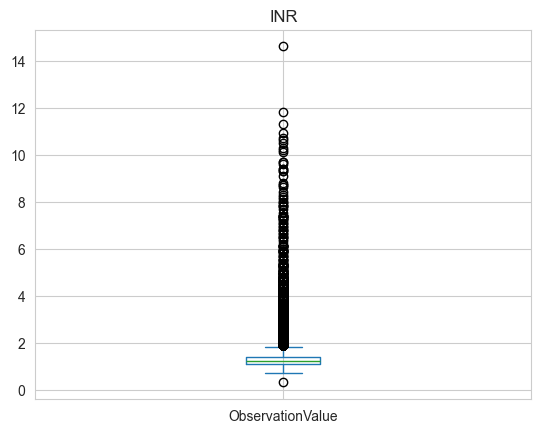

In [21]:
t = pd.concat([inr_2016_2019_data['ObservationValue'], inr_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('INR')
del t

The INR distributions are similar between 2012-2015 and 2016-2019. Units are unknown.

## pH

In [22]:
ph_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_pH.csv')
ph_2012_2015_data.head()

,StudyID,Observation,ObservationValue,Units,ObservationId,ObservationDtTm
0,16000,"pH, ART",7.25,NaN,PH,1/1/12 5:34 AM
1,16000,"pH, ART",7.32,NaN,PH,1/1/12 6:35 AM
2,16001,"pH, ART",7.38,NaN,PH,1/1/12 4:40 AM
3,16001,"pH, ART",7.31,NaN,PH,1/1/12 4:41 AM
4,16001,"pH, ART",7.39,NaN,PH,1/1/12 5:03 AM


In [23]:
ph_2012_2015_data.dtypes

StudyID               int64
Observation          object
ObservationValue    float64
Units               float64
ObservationId        object
ObservationDtTm      object
dtype: object

In [24]:
ph_2012_2015_data['Units'].value_counts()

Series([], Name: count, dtype: int64)

<Axes: >

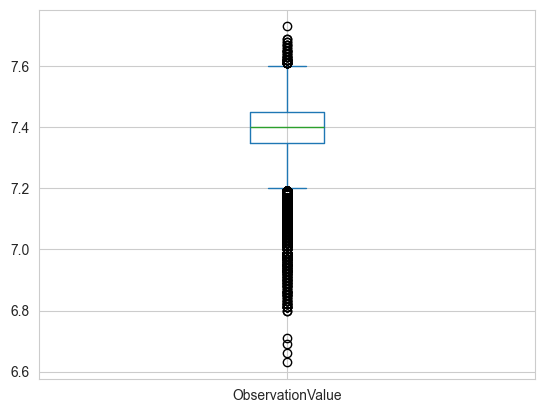

In [25]:
ph_2012_2015_data['ObservationValue'].plot.box()

In [26]:
ph_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_pH.csv')
ph_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm,Unnamed: 7,Unnamed: 8
0,3,1/1/16 2:43 AM,"pH, ART",1,2:48:00 AM,7.35,1/1/16 2:48 AM,NaN,NaN
1,3,1/1/16 2:43 AM,"pH, ART",1,7:29:00 AM,7.38,1/1/16 7:29 AM,NaN,NaN
2,3,1/1/16 2:43 AM,"pH, ART",1,12:10:00 PM,7.45,1/1/16 12:10 PM,NaN,NaN
3,3,1/1/16 2:43 AM,"pH, ART",3,11:20:00 AM,7.42,1/3/16 11:20 AM,NaN,NaN
4,3,1/1/16 2:43 AM,"pH, ART",3,2:20:00 PM,7.43,1/3/16 2:20 PM,NaN,NaN


In [27]:
ph_2016_2019_data.dtypes

StudyID               int64
AdmitDtTm            object
Observation          object
DAY                   int64
TIME                 object
ObservationValue    float64
ObservationDtTm      object
Unnamed: 7          float64
Unnamed: 8          float64
dtype: object

<Axes: >

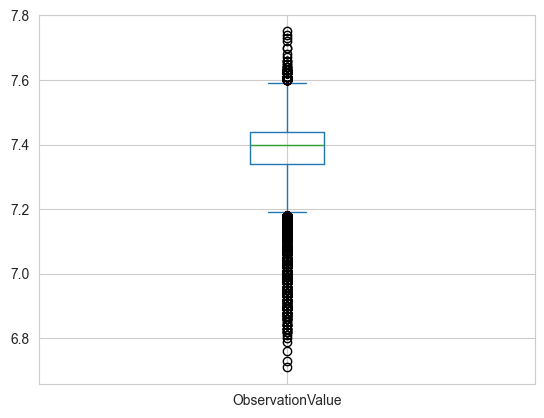

In [28]:
ph_2016_2019_data['ObservationValue'].plot.box()

count    80005.000000
mean         7.384068
std          0.090437
min          6.630000
25%          7.340000
50%          7.400000
75%          7.440000
max          7.750000
Name: ObservationValue, dtype: float64


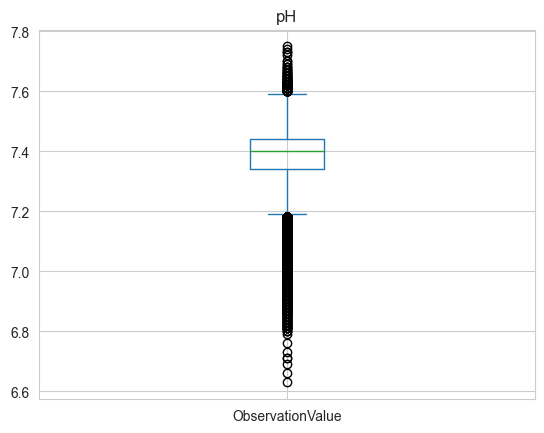

In [29]:
t = pd.concat([ph_2016_2019_data['ObservationValue'], ph_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('pH')
del t

The pH distributions are similar between 2012-2015 and 2016-2019. Units are unknown.

## FiO2

In [30]:
fio2_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_FiO2.csv')
fio2_2012_2015_data.head()

,StudyID,Observation,ObservationValue,Units,ObservationId,ObservationDtTm,SpecimenReceivedDtTm
0,16001,FI (O2) %,100.0,%,FIO2,1/1/12 5:03,1/1/12 5:03
1,16001,FI (O2) %,100.0,%,FIO2,1/1/12 5:41,1/1/12 5:41
2,16001,FI (O2) %,100.0,%,FIO2,1/1/12 7:45,1/1/12 7:57
3,16001,FI (O2) %,50.0,%,FIO2,1/1/12 11:40,1/1/12 11:49
4,16001,FI (O2) %,40.0,%,FIO2,1/1/12 15:10,1/1/12 15:18


In [31]:
fio2_2012_2015_data.dtypes

StudyID                   int64
Observation              object
ObservationValue        float64
Units                    object
ObservationId            object
ObservationDtTm          object
SpecimenReceivedDtTm     object
dtype: object

In [32]:
fio2_2012_2015_data['Units'].value_counts()

Units
%    26171
Name: count, dtype: int64

<Axes: >

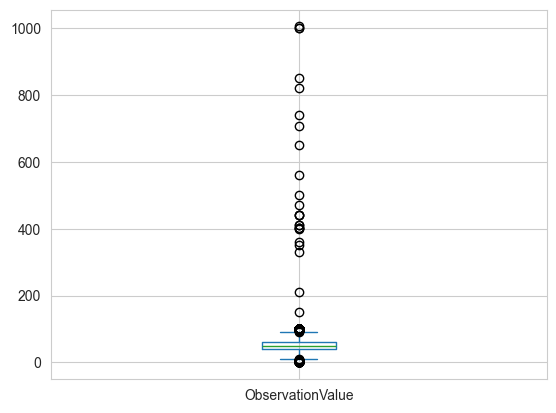

In [33]:
fio2_2012_2015_data['ObservationValue'].plot.box()

In [34]:
fio2_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_FiO2.csv')
fio2_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm,Unnamed: 7,Unnamed: 8
0,3,1/1/16 2:43 AM,FI (O2) %,1,2:48:00 AM,100.0,1/1/16 2:48 AM,NaN,NaN
1,3,1/1/16 2:43 AM,FI (O2) %,1,7:29:00 AM,100.0,1/1/16 7:29 AM,NaN,NaN
2,3,1/1/16 2:43 AM,FI (O2) %,1,12:10:00 PM,40.0,1/1/16 12:10 PM,NaN,NaN
3,3,1/1/16 2:43 AM,FI (O2) %,3,11:20:00 AM,30.0,1/3/16 11:20 AM,NaN,NaN
4,3,1/1/16 2:43 AM,FI (O2) %,3,2:20:00 PM,30.0,1/3/16 2:20 PM,NaN,NaN


In [35]:
fio2_2016_2019_data.dtypes

StudyID               int64
AdmitDtTm            object
Observation          object
DAY                   int64
TIME                 object
ObservationValue    float64
ObservationDtTm      object
Unnamed: 7          float64
Unnamed: 8          float64
dtype: object

<Axes: >

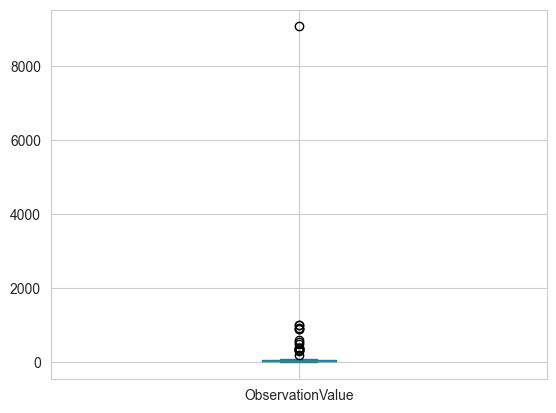

In [36]:
fio2_2016_2019_data['ObservationValue'].plot.box()

<Axes: >

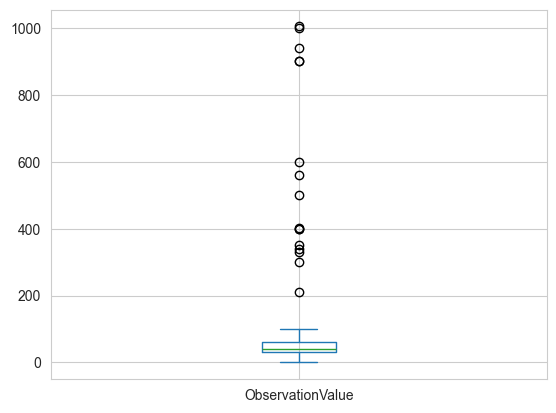

In [37]:
fio2_2016_2019_data[fio2_2016_2019_data['ObservationValue'] < 5000]['ObservationValue'].plot.box()

count    53568.000000
mean        53.547166
std         48.661882
min          0.000000
25%         40.000000
50%         40.000000
75%         60.000000
max       9080.000000
Name: ObservationValue, dtype: float64


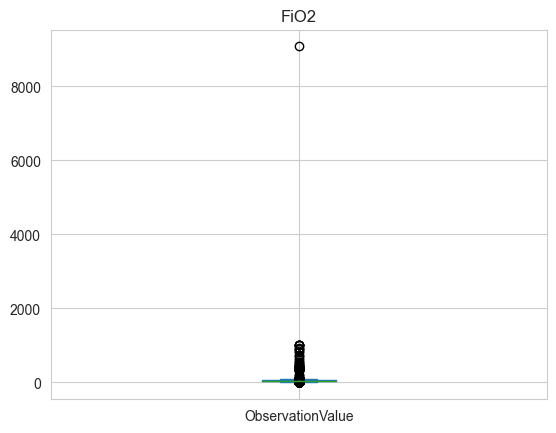

In [38]:
t = pd.concat([fio2_2012_2015_data['ObservationValue'], fio2_2016_2019_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('FiO2')
del t

FiO2 distributions are similar between 2012-2015 and 2016-2019. Units are percentage. There is at least one outlier in the 2016-2019 data.

# FiO2 Corrected

In [39]:
fio2_corrected_2012_2015_data = pd.read_csv('<path_to_dataset>/2012-2015_Corrected_FiO2.csv')
fio2_corrected_2012_2015_data.head()

,StudyID,Observation,FiO2,Units,ObservationId,ObservationDtTm,SpecimenReceivedDtTm
0,16001,FI (O2) %,100.0,%,FIO2,2012-01-01 05:03:00,1/1/12 5:03
1,16001,FI (O2) %,100.0,%,FIO2,2012-01-01 05:41:00,1/1/12 5:41
2,16001,FI (O2) %,100.0,%,FIO2,2012-01-01 07:45:00,1/1/12 7:57
3,16001,FI (O2) %,50.0,%,FIO2,2012-01-01 11:40:00,1/1/12 11:49
4,16001,FI (O2) %,40.0,%,FIO2,2012-01-01 15:10:00,1/1/12 15:18


In [40]:
fio2_corrected_2012_2015_data.dtypes

StudyID                   int64
Observation              object
FiO2                    float64
Units                    object
ObservationId            object
ObservationDtTm          object
SpecimenReceivedDtTm     object
dtype: object

In [41]:
fio2_corrected_2012_2015_data['Units'].value_counts()

Units
%    26171
Name: count, dtype: int64

<Axes: >

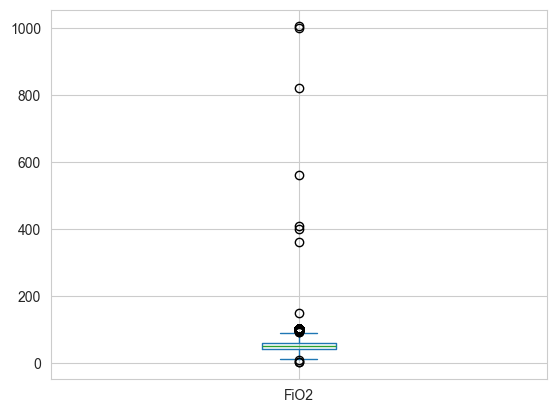

In [42]:
fio2_corrected_2012_2015_data['FiO2'].plot.box()

In [43]:
fio2_corrected_2016_2019_data = pd.read_csv('<path_to_dataset>/2016-2019_Corrected_FiO2.csv')
fio2_corrected_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,FiO2,ObservationDtTm,Unnamed: 7,Unnamed: 8
0,3,1/1/16 2:43 AM,FI (O2) %,1,2:48:00 AM,100.0,2016-01-01 02:48:00,NaN,NaN
1,3,1/1/16 2:43 AM,FI (O2) %,1,7:29:00 AM,100.0,2016-01-01 07:29:00,NaN,NaN
2,3,1/1/16 2:43 AM,FI (O2) %,1,12:10:00 PM,40.0,2016-01-01 12:10:00,NaN,NaN
3,3,1/1/16 2:43 AM,FI (O2) %,3,11:20:00 AM,30.0,2016-01-03 11:20:00,NaN,NaN
4,3,1/1/16 2:43 AM,FI (O2) %,3,2:20:00 PM,30.0,2016-01-03 14:20:00,NaN,NaN


In [44]:
fio2_corrected_2016_2019_data.dtypes

StudyID              int64
AdmitDtTm           object
Observation         object
DAY                  int64
TIME                object
FiO2               float64
ObservationDtTm     object
Unnamed: 7         float64
Unnamed: 8         float64
dtype: object

<Axes: >

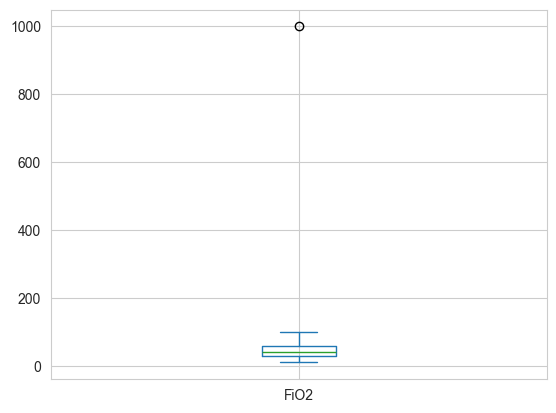

In [45]:
fio2_corrected_2016_2019_data['FiO2'].plot.box()

count    53567.000000
mean        53.335841
std         25.871980
min         16.000000
25%         40.000000
50%         40.000000
75%         60.000000
max       1005.000000
Name: FiO2, dtype: float64


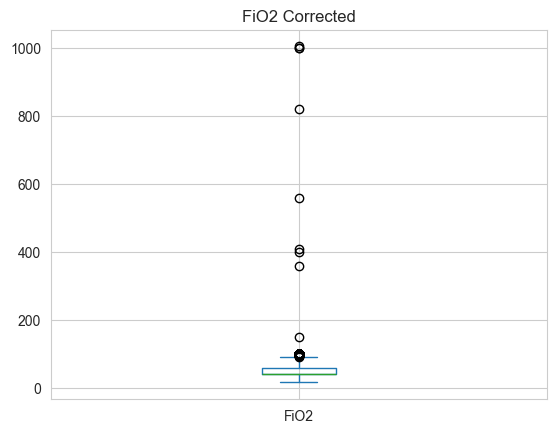

In [46]:
t = pd.concat([fio2_corrected_2012_2015_data['FiO2'], fio2_corrected_2016_2019_data['FiO2']])
t[t <= 9 | np.isclose(t, 9)] = 100.0 * (t[t <= 9 | np.isclose(t, 9)] * 0.038 + 0.208)
t[(t > 9) & (t <= 15) | np.isclose(t, 15)] = 6.0 * t[(t > 9) & (t <= 15) | np.isclose(t, 15)]
print(t.describe())
ax = t.plot.box()
ax.set_title('FiO2 Corrected')
del t

FiO2 Corrected distributions are similar between 2012-2015 and 2016-2019. Units are percentage. There appear to be fewer outliers in the corrected FiO2 data.

## RR

In [183]:
rr_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_RR.csv')
rr_2012_2015_data.head()

,STUDYID,DAY,TIME,RESULT_VAL,EVENT_CD_DESCR,RESULT_UNITS_CD_DESCR
0,18501,1,12:53:00.0000000,12.0,Respiratory Rate,br/min
1,18501,1,13:02:00.0000000,12.0,Respiratory Rate,br/min
2,18501,1,13:15:00.0000000,12.0,Respiratory Rate,br/min
3,18501,1,13:30:00.0000000,15.0,Respiratory Rate,br/min
4,18501,1,13:45:00.0000000,15.0,Respiratory Rate,br/min


In [ ]:
rr_2012_2015_data['RESULT_VAL'].plot.box()

In [184]:
rr_2012_2015_data.dtypes

STUDYID                    int64
DAY                        int64
TIME                      object
RESULT_VAL               float64
EVENT_CD_DESCR            object
RESULT_UNITS_CD_DESCR     object
dtype: object

In [47]:
rr_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_RR.csv')
rr_2016_2019_data.head()

/var/folders/vf/695131157rl2pvb9_s5zykbh0000gn/T/ipykernel_8426/3005441506.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  rr_2016_2019_data = pd.read_csv('/Users/larry/Documents/UWT/Thesis Work/rec_sys/datasets/trauma_icu_resuscitation/MASTER_2016-2019_RR.csv')


,StudyID,Day,EventEndDtTm,Time,Value,Measurement
0,1,1,2016-01-01 02:12:00,2:12:00 AM,14.0,RR
1,1,1,2016-01-01 02:18:00,2:18:00 AM,16.0,NaN
2,1,1,2016-01-01 04:40:00,4:40:00 AM,16.0,NaN
3,1,1,2016-01-01 05:55:00,5:55:00 AM,16.0,NaN
4,1,1,2016-01-01 06:12:00,6:12:00 AM,16.0,NaN


In [48]:
rr_2016_2019_data.dtypes

StudyID           int64
Day               int64
EventEndDtTm     object
Time             object
Value           float64
Measurement      object
dtype: object

In [49]:
rr_2016_2019_data['Measurement'].value_counts()

Measurement
RR    2
Name: count, dtype: int64

count    2.366578e+06
mean     1.838099e+01
std      5.823886e+00
min      0.000000e+00
25%      1.500000e+01
50%      1.700000e+01
75%      2.000000e+01
max      1.210000e+02
dtype: float64


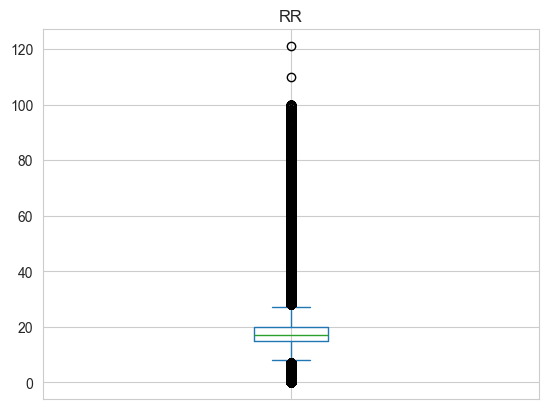

In [185]:
t = pd.concat([rr_2016_2019_data['Value'], rr_2012_2015_data['RESULT_VAL']])
print(t.describe())
ax = t.plot.box()
ax.set_title('RR')
del t

We only have RR for 2016-2019. Units are RR - I dont know what this means.

## MAP

In [52]:
map_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_MAP.csv')
map_2012_2015_data.head()

,Unnamed: 0,StudyID,AdmitDtTm,ICU_AdmitDtTm,Day,Time,Value,EVENT_CD_DESCR,EventEndDtTm
0,0,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:37:00 AM,92.0,MAP - Noninvasive,2013-05-15 02:37:00
1,1,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:48:00 AM,96.0,MAP - Noninvasive,2013-05-15 02:48:00
2,2,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,3:07:00 AM,110.0,MAP - Noninvasive,2013-05-15 03:07:00
3,3,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,4:00:00 AM,92.0,MAP - Noninvasive,2013-05-15 04:00:00
4,4,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,5:00:00 AM,103.0,MAP - Noninvasive,2013-05-15 05:00:00


In [53]:
map_2012_2015_data.dtypes

Unnamed: 0          int64
StudyID             int64
AdmitDtTm          object
ICU_AdmitDtTm      object
Day                 int64
Time               object
Value             float64
EVENT_CD_DESCR     object
EventEndDtTm       object
dtype: object

<Axes: >

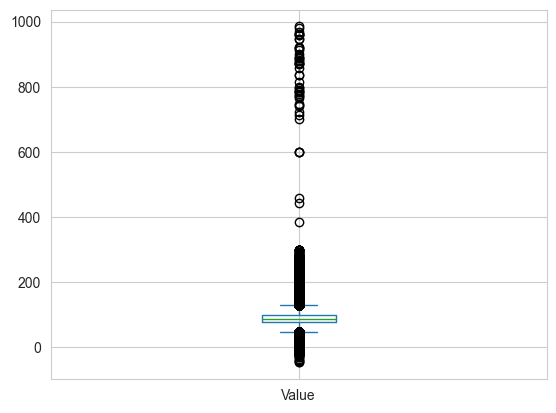

In [54]:
map_2012_2015_data['Value'].plot.box()

In [55]:
map_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_MAP.csv')
map_2016_2019_data.head()

,StudyID,Day,Measurement,Unnamed: 3,EventEndDtTm,Time,Value
0,1,1,MAP - Noninvasive,NaN,2016-01-01 06:12:00,6:12:00 AM,86.0
1,1,1,MAP - Noninvasive,NaN,2016-01-01 07:34:00,7:34:00 AM,93.0
2,1,1,MAP - Noninvasive,NaN,2016-01-01 11:30:00,11:30:00 AM,89.0
3,1,1,MAP - Arterial,NaN,2016-01-01 11:30:00,11:30:00 AM,91.0
4,1,1,MAP - Noninvasive,NaN,2016-01-01 11:45:00,11:45:00 AM,90.0


In [56]:
map_2016_2019_data.dtypes

StudyID           int64
Day               int64
Measurement      object
Unnamed: 3      float64
EventEndDtTm     object
Time             object
Value           float64
dtype: object

<Axes: >

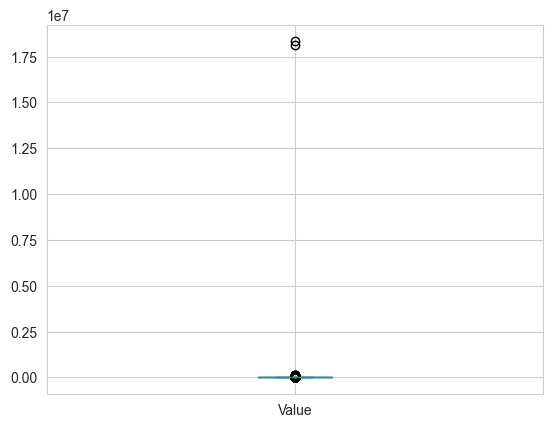

In [57]:
map_2016_2019_data['Value'].plot.box()

<Axes: >

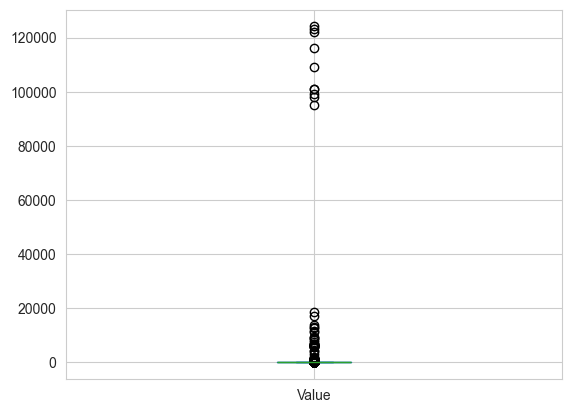

In [58]:
map_2016_2019_data[map_2016_2019_data['Value'] < 1000000]['Value'].plot.box()

count    2.097112e+06
mean     1.054666e+02
std      1.779717e+04
min     -4.700000e+01
25%      7.600000e+01
50%      8.600000e+01
75%      9.700000e+01
max      1.831980e+07
Name: Value, dtype: float64


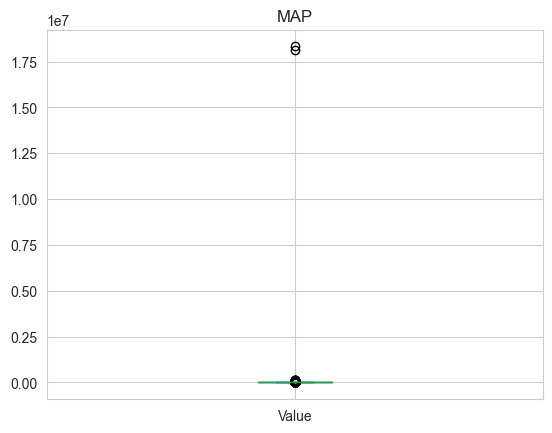

In [59]:
t = pd.concat([map_2016_2019_data['Value'], map_2012_2015_data['Value']])
print(t.describe())
ax = t.plot.box()
ax.set_title('MAP')
del t

count    2.097093e+06
mean     8.752273e+01
std      2.802434e+01
min     -4.700000e+01
25%      7.600000e+01
50%      8.600000e+01
75%      9.700000e+01
max      9.497000e+03
Name: Value, dtype: float64


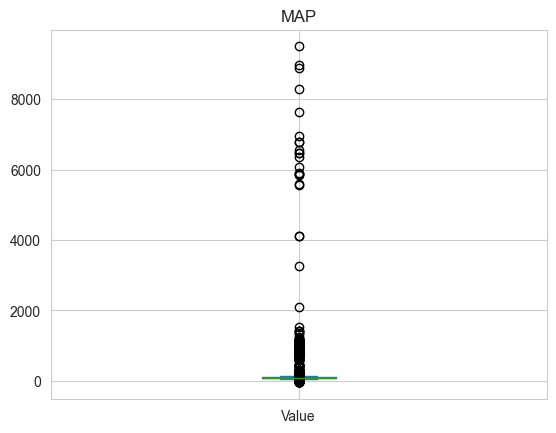

In [60]:
t = pd.concat([map_2016_2019_data['Value'], map_2012_2015_data['Value']])
t = t[t < 10000]
print(t.describe())
ax = t.plot.box()
ax.set_title('MAP')
del t

Both MAP datasets contain many outliers. Units are unknown but assumed to be mmHg. We need domain experts to review these values.

## HR

In [61]:
hr_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_HR.csv')
hr_2012_2015_data.head()

,Unnamed: 0,StudyID,AdmitDtTm,ICU_AdmitDtTm,Day,Time,Value,EVENT_CD_DESCR,EventEndDtTm
0,0,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:37:00 AM,72.0,Heart Rate,2013-05-15 02:37:00
1,1,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:48:00 AM,76.0,Heart Rate,2013-05-15 02:48:00
2,2,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,3:07:00 AM,76.0,Heart Rate,2013-05-15 03:07:00
3,3,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,4:00:00 AM,79.0,Heart Rate,2013-05-15 04:00:00
4,4,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,5:00:00 AM,71.0,Heart Rate,2013-05-15 05:00:00


In [62]:
hr_2012_2015_data.dtypes

Unnamed: 0          int64
StudyID             int64
AdmitDtTm          object
ICU_AdmitDtTm      object
Day                 int64
Time               object
Value             float64
EVENT_CD_DESCR     object
EventEndDtTm       object
dtype: object

<Axes: >

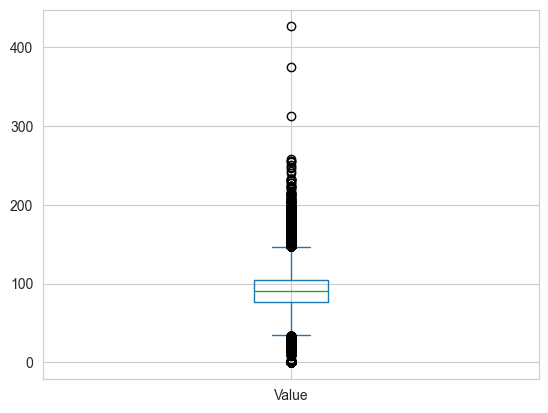

In [63]:
hr_2012_2015_data['Value'].plot.box()

In [64]:
hr_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_HR.csv')
hr_2016_2019_data.head()

/var/folders/vf/695131157rl2pvb9_s5zykbh0000gn/T/ipykernel_8426/3422275713.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  hr_2016_2019_data = pd.read_csv('/Users/larry/Documents/UWT/Thesis Work/rec_sys/datasets/trauma_icu_resuscitation/MASTER_2016-2019_HR.csv')


,StudyID,Day,EventEndDtTm,Time,Value,Measurement
0,1,1,2016-01-01 02:12:00,2:12:00 AM,68.0,Heart Rate
1,1,1,2016-01-01 02:18:00,2:18:00 AM,75.0,Heart Rate
2,1,1,2016-01-01 04:40:00,4:40:00 AM,77.0,Heart Rate
3,1,1,2016-01-01 05:55:00,5:55:00 AM,79.0,Heart Rate
4,1,1,2016-01-01 06:12:00,6:12:00 AM,66.0,Heart Rate


In [65]:
hr_2016_2019_data.dtypes

StudyID           int64
Day               int64
EventEndDtTm     object
Time             object
Value           float64
Measurement      object
dtype: object

In [66]:
hr_2016_2019_data['Measurement'].value_counts()

Measurement
Heart Rate    7267
Name: count, dtype: int64

<Axes: >

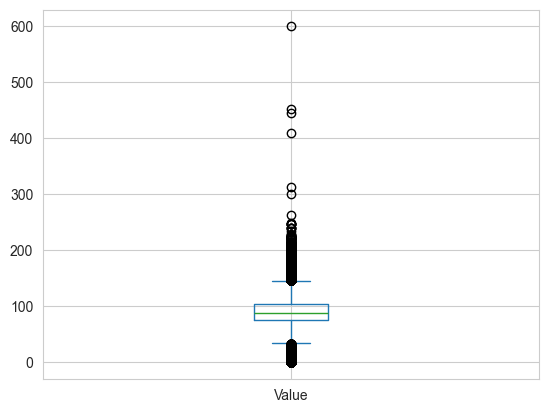

In [67]:
hr_2016_2019_data['Value'].plot.box()

count    2.152900e+06
mean     9.087715e+01
std      2.032494e+01
min      0.000000e+00
25%      7.600000e+01
50%      9.000000e+01
75%      1.040000e+02
max      6.000000e+02
Name: Value, dtype: float64


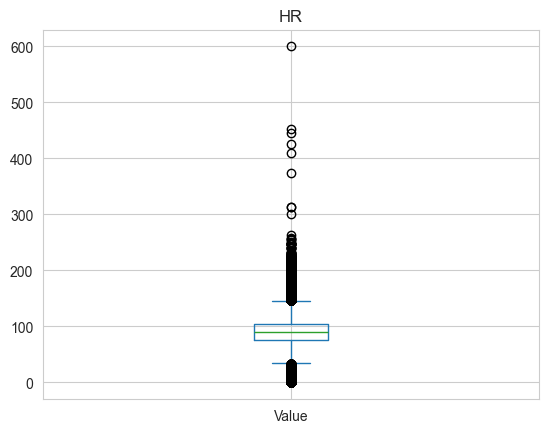

In [68]:
t = pd.concat([hr_2016_2019_data['Value'], hr_2012_2015_data['Value']])
print(t.describe())
ax = t.plot.box()
ax.set_title('HR')
del t

The distributions for HR are similar between 2012-2015 and 2016-2019. Units are assumed to be BPM.

## SBP

In [69]:
sbp_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_SBP.csv')
sbp_2012_2015_data.head()

,Unnamed: 0,StudyID,AdmitDtTm,ICU_AdmitDtTm,Day,Time,Value,EVENT_CD_DESCR,EventEndDtTm
0,0,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:37:00 AM,120.0,SBP - Noninvasive,2013-05-15 02:37:00
1,1,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:48:00 AM,141.0,SBP - Noninvasive,2013-05-15 02:48:00
2,2,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,3:07:00 AM,138.0,SBP - Noninvasive,2013-05-15 03:07:00
3,3,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,4:00:00 AM,132.0,SBP - Noninvasive,2013-05-15 04:00:00
4,4,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,5:00:00 AM,140.0,SBP - Noninvasive,2013-05-15 05:00:00


In [70]:
sbp_2012_2015_data.dtypes

Unnamed: 0          int64
StudyID             int64
AdmitDtTm          object
ICU_AdmitDtTm      object
Day                 int64
Time               object
Value             float64
EVENT_CD_DESCR     object
EventEndDtTm       object
dtype: object

<Axes: >

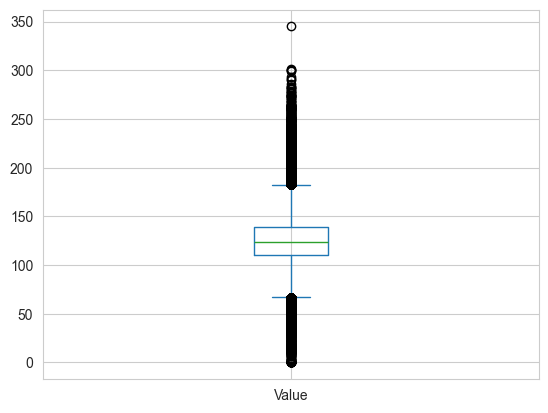

In [71]:
sbp_2012_2015_data['Value'].plot.box()

In [72]:
sbp_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_SBP.csv')
sbp_2016_2019_data.head()

,StudyID,Day,Measurement,EventEndDtTm,Time,Value
0,1,1,SBP - Noninvasive,2016-01-01 02:12:00,2:12:00 AM,106.0
1,1,1,SBP - Noninvasive,2016-01-01 02:18:00,2:18:00 AM,138.0
2,1,1,SBP - Noninvasive,2016-01-01 04:40:00,4:40:00 AM,108.0
3,1,1,SBP - Noninvasive,2016-01-01 05:55:00,5:55:00 AM,110.0
4,1,1,SBP - Noninvasive,2016-01-01 06:12:00,6:12:00 AM,122.0


In [73]:
sbp_2016_2019_data.dtypes

StudyID           int64
Day               int64
Measurement      object
EventEndDtTm     object
Time             object
Value           float64
dtype: object

<Axes: >

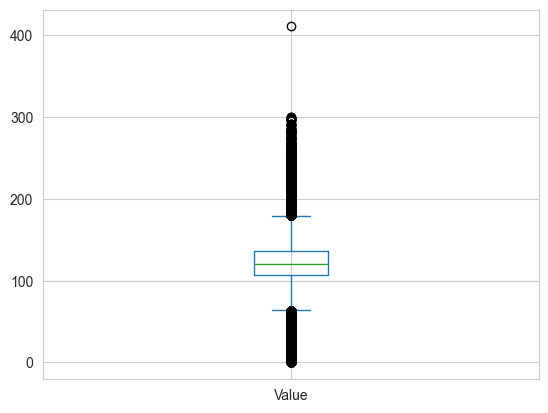

In [74]:
sbp_2016_2019_data['Value'].plot.box()

count    2.229706e+06
mean     1.232469e+02
std      2.168140e+01
min      0.000000e+00
25%      1.080000e+02
50%      1.220000e+02
75%      1.370000e+02
max      4.110000e+02
Name: Value, dtype: float64


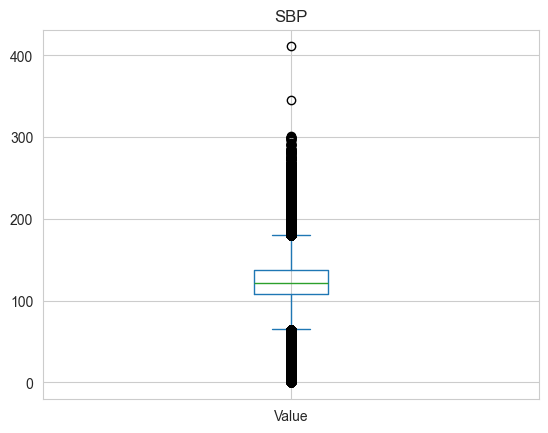

In [75]:
t = pd.concat([sbp_2016_2019_data['Value'], sbp_2012_2015_data['Value']])
print(t.describe())
ax = t.plot.box()
ax.set_title('SBP')
del t

The distributions for SBP are similar between 2012-2015 and 2016-2019. Units are unknown.

# DBP

In [76]:
dbp_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_DBP.csv')
dbp_2012_2015_data.rename(columns={'STUDYID': 'StudyID'}, inplace=True)
dbp_2012_2015_data.head()

,StudyID,DAY,TIME,RESULT_VAL,EVENT_CD_DESCR
0,16000,1,6:42:00 AM,66.0,DBP - Noninvasive
1,16000,1,7:00:00 AM,66.0,DBP - Noninvasive
2,16000,1,7:48:00 AM,58.0,DBP - Noninvasive
3,16000,1,10:22:00 AM,99.0,DBP - Noninvasive
4,16000,1,10:30:00 AM,74.0,DBP - Noninvasive


In [77]:
dbp_2012_2015_data['DAY'].mean()

9.912613526369578

In [78]:
type(dbp_2012_2015_data['TIME'].iloc[0])

str

In [79]:
pd.to_datetime(dbp_2012_2015_data['TIME'], format='%H:%M:%S %p').dt.time

0          06:42:00
1          07:00:00
2          07:48:00
3          10:22:00
4          10:30:00
             ...   
1036208    07:00:00
1036209    11:38:00
1036210    03:55:00
1036211    08:18:00
1036212    12:12:00
Name: TIME, Length: 1036213, dtype: object

In [80]:
dbp_2012_2015_data['StudyID'].unique().shape[0]

7607

In [81]:
dbp_2012_2015_data.dtypes

StudyID             int64
DAY                 int64
TIME               object
RESULT_VAL        float64
EVENT_CD_DESCR     object
dtype: object

<Axes: >

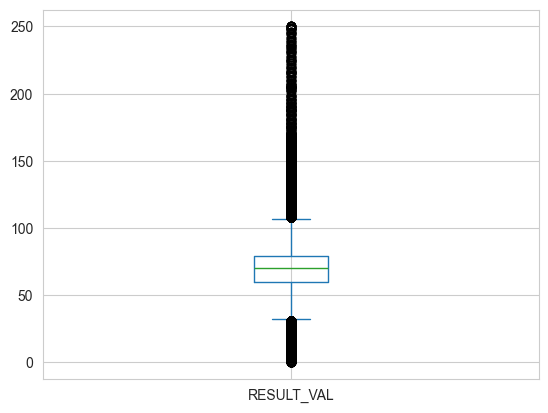

In [82]:
dbp_2012_2015_data['RESULT_VAL'].plot.box()

In [83]:
dbp_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_DBP.csv')
dbp_2016_2019_data.head()

,StudyID,Day,Measurement,EventEndDtTm,Time,Value
0,1,1,DBP - Noninvasive,2016-01-01 02:12:00,2:12:00 AM,56.0
1,1,1,DBP - Noninvasive,2016-01-01 02:18:00,2:18:00 AM,91.0
2,1,1,DBP - Noninvasive,2016-01-01 04:40:00,4:40:00 AM,66.0
3,1,1,DBP - Noninvasive,2016-01-01 05:55:00,5:55:00 AM,69.0
4,1,1,DBP - Noninvasive,2016-01-01 06:12:00,6:12:00 AM,71.0


In [84]:
dbp_2016_2019_data.dtypes

StudyID           int64
Day               int64
Measurement      object
EventEndDtTm     object
Time             object
Value           float64
dtype: object

<Axes: >

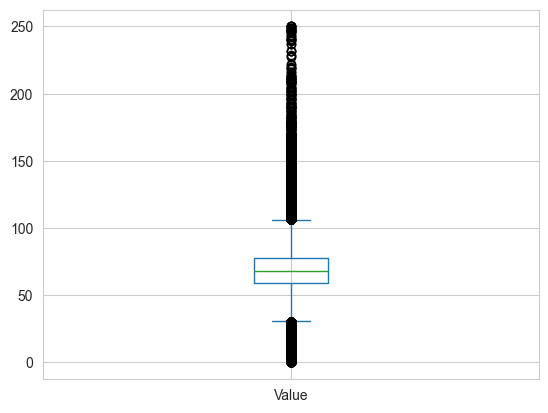

In [85]:
dbp_2016_2019_data['Value'].plot.box()

count    2.534838e+06
mean     6.958021e+01
std      1.478156e+01
min      0.000000e+00
25%      5.900000e+01
50%      6.900000e+01
75%      7.900000e+01
max      2.500000e+02
dtype: float64


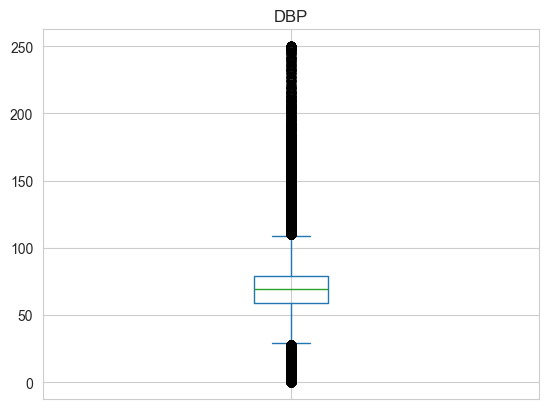

In [86]:
t = pd.concat([dbp_2016_2019_data['Value'], dbp_2012_2015_data['RESULT_VAL']])
print(t.describe())
ax = t.plot.box()
ax.set_title('DBP')
del t

The distributions for DBP are similar between 2012-2015 and 2016-2019. Units are unknown.

## Temp

In [87]:
temp_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_Temp.csv')
temp_2012_2015_data.head()

,Unnamed: 0,StudyID,AdmitDtTm,ICU_AdmitDtTm,Day,Time,Value,EVENT_CD_DESCR,EventEndDtTm
0,0,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,2:37:00 AM,36.3,Temperature - C,2013-05-15 02:37:00
1,1,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,4:00:00 AM,36.5,Temperature - C,2013-05-15 04:00:00
2,2,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,8:13:00 AM,36.3,Temperature - C,2013-05-15 08:13:00
3,3,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,12:00:00 PM,36.5,Temperature - C,2013-05-15 12:00:00
4,4,19334,2013-05-14 21:58:00,2013-05-15 02:27:00,2,4:00:00 PM,36.2,Temperature - C,2013-05-15 16:00:00


In [88]:
temp_2012_2015_data.dtypes

Unnamed: 0          int64
StudyID             int64
AdmitDtTm          object
ICU_AdmitDtTm      object
Day                 int64
Time               object
Value             float64
EVENT_CD_DESCR     object
EventEndDtTm       object
dtype: object

<Axes: >

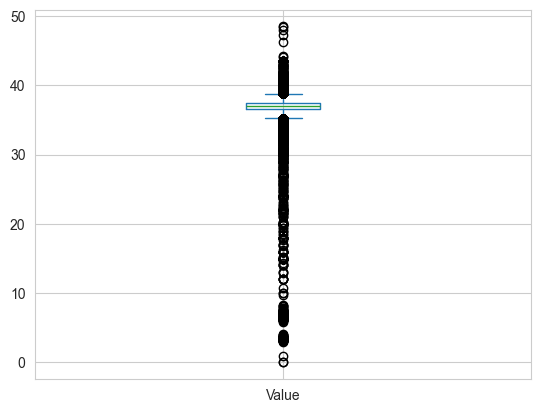

In [89]:
temp_2012_2015_data['Value'].plot.box()

In [90]:
temp_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_Temp.csv')
temp_2016_2019_data.head()

/var/folders/vf/695131157rl2pvb9_s5zykbh0000gn/T/ipykernel_8426/1568959687.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_2016_2019_data = pd.read_csv('/Users/larry/Documents/UWT/Thesis Work/rec_sys/datasets/trauma_icu_resuscitation/MASTER_2016-2019_Temp.csv')


,StudyID,AdmitDtTm,Day,EventEndDtTm,Time,Value,Measurement
0,1,1/1/16 2:07 AM,1,2016-01-01 02:12:00,2:12:00 AM,36.6,Temp
1,1,1/1/16 2:07 AM,1,2016-01-01 06:12:00,6:12:00 AM,36.6,NaN
2,1,1/1/16 2:07 AM,1,2016-01-01 07:34:00,7:34:00 AM,37.3,NaN
3,1,1/1/16 2:07 AM,1,2016-01-01 11:30:00,11:30:00 AM,36.6,NaN
4,1,1/1/16 2:07 AM,1,2016-01-01 12:00:00,12:00:00 PM,36.5,NaN


In [91]:
temp_2016_2019_data.dtypes

StudyID           int64
AdmitDtTm        object
Day               int64
EventEndDtTm     object
Time             object
Value           float64
Measurement      object
dtype: object

<Axes: >

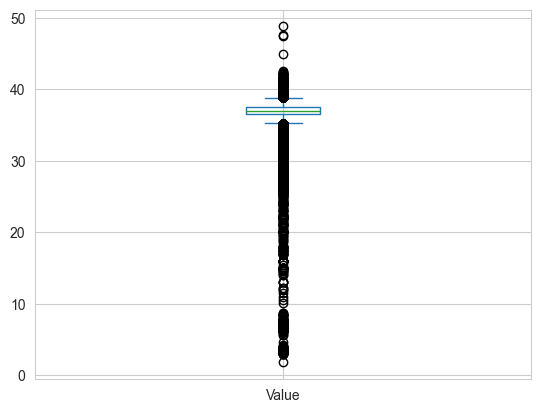

In [92]:
temp_2016_2019_data['Value'].plot.box()

count    1.123771e+06
mean     3.704973e+01
std      9.953749e-01
min      0.000000e+00
25%      3.660000e+01
50%      3.700000e+01
75%      3.750000e+01
max      4.880000e+01
Name: Value, dtype: float64


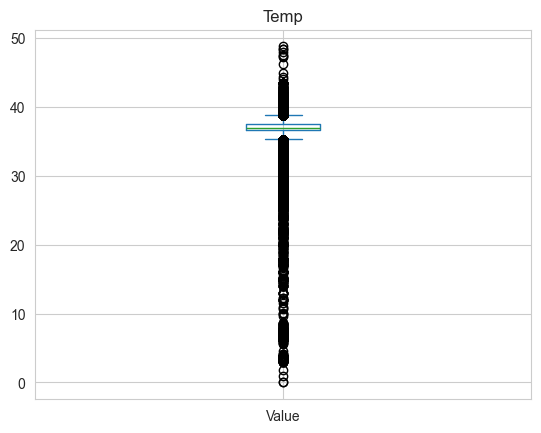

In [93]:
t = pd.concat([temp_2016_2019_data['Value'], temp_2012_2015_data['Value']])
print(t.describe())
ax = t.plot.box()
ax.set_title('Temp')
del t

The distributions for Temp are similar between 2012-2015 and 2016-2019. Units are assumed to be Celsius.

## UOP

In [94]:
uop_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_Hourly_UOP_Total.csv')
uop_2012_2015_data.head()

,StudyID,Weight,AKI,Hours_from_ICU_Admit,Volume,cc_per_kg
0,18608,79.5,0,1.0,400.0,5.031447
1,18608,79.5,0,2.0,100.0,1.257862
2,18608,79.5,0,3.0,175.0,2.201258
3,18608,79.5,0,4.0,100.0,1.257862
4,18608,79.5,0,5.0,50.0,0.628931


In [95]:
uop_2012_2015_data.dtypes

StudyID                   int64
Weight                  float64
AKI                       int64
Hours_from_ICU_Admit    float64
Volume                  float64
cc_per_kg               float64
dtype: object

<Axes: >

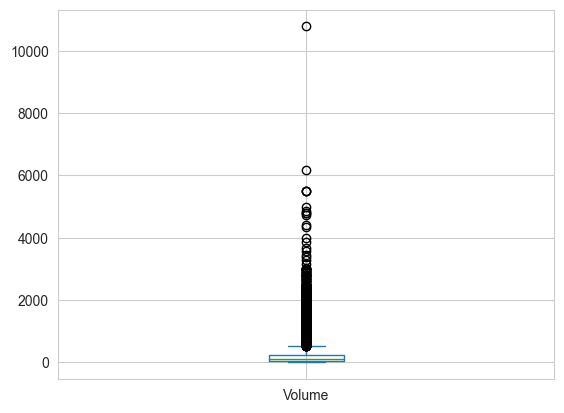

In [96]:
uop_2012_2015_data['Volume'].plot.box()

In [97]:
uop_2012_2015_data['Volume'].describe()

count    98679.000000
mean       207.913193
std        264.725792
min          0.000000
25%         60.000000
50%        120.000000
75%        250.000000
max      10780.000000
Name: Volume, dtype: float64

In [98]:
uop_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_UOP_no_dupes.csv')
uop_2016_2019_data.head()

,StudyID,Unnamed: 1,StudyID.1,DAY,EventEndDtTm,Volume,Type
0,1,0,1,1,2016-01-01 11:45:00,160.0,Foley
1,1,1,1,1,2016-01-01 17:00:00,25.0,Void
2,1,2,1,1,2016-01-01 21:37:00,150.0,Foley
3,1,3,1,1,2016-01-01 22:00:00,30.0,Foley
4,1,4,1,1,2016-01-01 23:00:00,30.0,Foley


In [99]:
uop_2016_2019_data.dtypes

StudyID           int64
Unnamed: 1        int64
StudyID.1         int64
DAY               int64
EventEndDtTm     object
Volume          float64
Type             object
dtype: object

<Axes: >

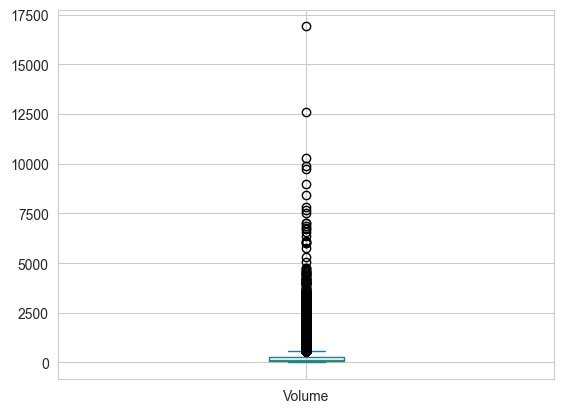

In [100]:
uop_2016_2019_data['Volume'].plot.box()

In [101]:
uop_2016_2019_data['Volume'].describe()

count    744390.000000
mean        207.630313
std         252.837170
min           0.000000
25%          60.000000
50%         120.000000
75%         260.000000
max       16900.000000
Name: Volume, dtype: float64

count    843069.000000
mean        207.663423
std         254.257282
min           0.000000
25%          60.000000
50%         120.000000
75%         250.000000
max       16900.000000
Name: Volume, dtype: float64


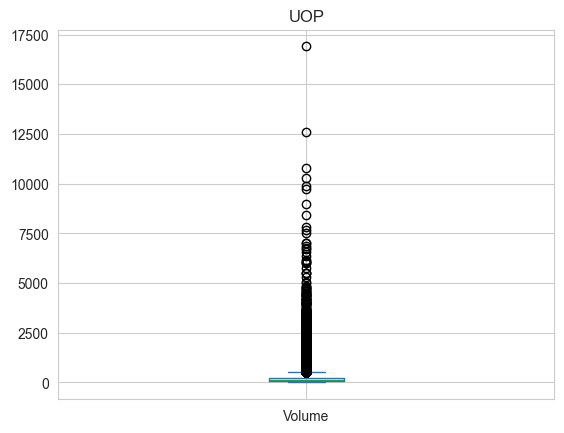

In [102]:
t = pd.concat([uop_2016_2019_data['Volume'], uop_2012_2015_data['Volume']])
print(t.describe())
ax = t.plot.box()
ax.set_title('UOP')
del t

The distributions for UOP are similar between 2012-2015 and 2016-2019. Units are unknown.

## Lactate

In [103]:
lactate_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_lactate.csv')
lactate_2012_2015_data.head()

,StudyID,MRN,AdmitDate,Observation,ObservationValue,Units,ObservationId,ObservationDtTm,SpecimenReceivedDtTm
0,18608,H0180077,2013-01-21,"L_Lactate, Arterial Whole Bloo",9.4,mmol/L,WALAC,1/21/13 1:50 PM,1/21/13 1:53 PM
1,18608,H0180077,2013-01-21,"L_Lactate, Arterial Whole Bloo",3.4,mmol/L,WALAC,1/21/13 6:25 PM,1/21/13 6:31 PM
2,16351,H0233783,2012-02-28,"L_Lactate, Arterial Whole Bloo",2.4,mmol/L,WALAC,2/28/12 10:16 AM,2/28/12 2:04 PM
3,16351,H0233783,2012-02-28,"L_Lactate, Arterial Whole Bloo",0.9,mmol/L,WALAC,2/29/12 10:11 AM,2/29/12 10:17 AM
4,17769,H0410182,2012-09-08,"L_Lactate, Arterial Whole Bloo",0.6,mmol/L,WALAC,9/9/12 8:25 AM,9/9/12 9:18 AM


In [104]:
lactate_2012_2015_data.dtypes

StudyID                   int64
MRN                      object
AdmitDate                object
Observation              object
ObservationValue        float64
Units                    object
ObservationId            object
ObservationDtTm          object
SpecimenReceivedDtTm     object
dtype: object

In [105]:
lactate_2012_2015_data['Units'].value_counts()

Units
mmol/L    24026
Name: count, dtype: int64

<Axes: >

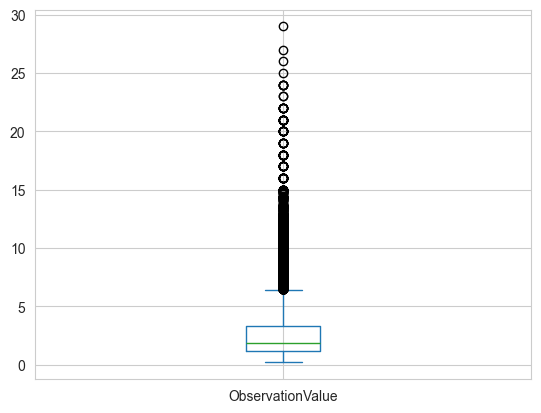

In [106]:
lactate_2012_2015_data['ObservationValue'].plot.box()

In [107]:
lactate_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_lactate.csv')
lactate_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm
0,3,1/1/16 2:43 AM,"L_Lactate, Arterial Whole Bloo",1,2:48:00 AM,5.2,1/1/16 2:48 AM
1,3,1/1/16 2:43 AM,"L_Lactate, Arterial Whole Bloo",1,7:29:00 AM,3.0,1/1/16 7:29 AM
2,3,1/1/16 2:43 AM,"L_Lactate, Arterial Whole Bloo",1,12:10:00 PM,3.1,1/1/16 12:10 PM
3,3,1/1/16 2:43 AM,"L_Lactate, Arterial Whole Bloo",3,11:20:00 AM,1.7,1/3/16 11:20 AM
4,3,1/1/16 2:43 AM,"L_Lactate, Arterial Whole Bloo",5,11:16:00 AM,1.8,1/5/16 11:16 AM


In [108]:
lactate_2016_2019_data.dtypes

StudyID               int64
AdmitDtTm            object
Observation          object
DAY                   int64
TIME                 object
ObservationValue    float64
ObservationDtTm      object
dtype: object

<Axes: >

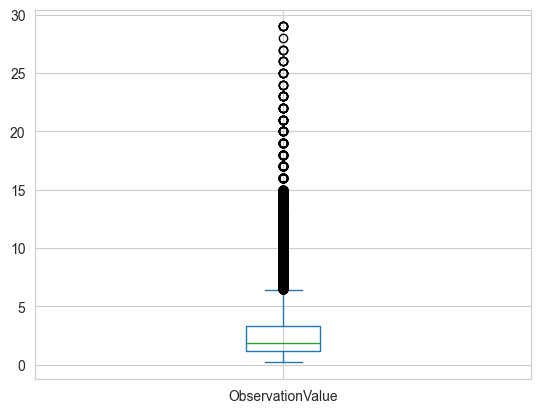

In [109]:
lactate_2016_2019_data['ObservationValue'].plot.box()

count    54837.000000
mean         2.736052
std          2.537702
min          0.200000
25%          1.200000
50%          1.900000
75%          3.300000
max         29.000000
Name: ObservationValue, dtype: float64


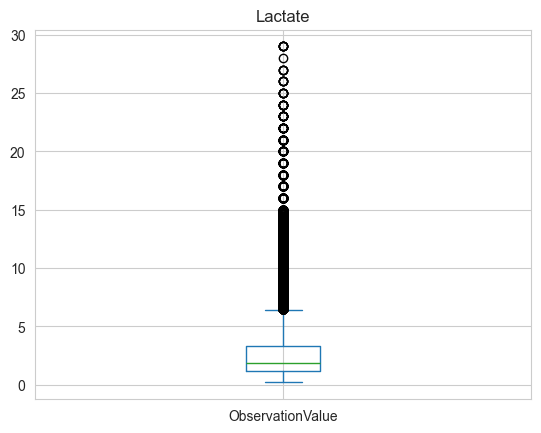

In [110]:
t = pd.concat([lactate_2016_2019_data['ObservationValue'], lactate_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('Lactate')
del t

The distributions for lactate are similar between 2012-2015 and 2016-2019. Units appear to be mmol/L.

# PaO2

In [111]:
pao2_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_PaO2.csv')
pao2_2012_2015_data.head()

,StudyID,Observation,ObservationValue,Units,ObservationId,ObservationDtTm,SpecimenReceivedDtTm
0,16000,"pO2, ART",115,mm Hg,PO2,1/1/12 5:34 AM,1/1/12 5:34 AM
1,16000,"pO2, ART",169,mm Hg,PO2,1/1/12 6:35 AM,1/1/12 6:41 AM
2,16001,"pO2, ART",455,mm Hg,PO2,1/1/12 4:40 AM,1/1/12 4:45 AM
3,16001,"pO2, ART",542,mm Hg,PO2,1/1/12 4:41 AM,1/1/12 4:46 AM
4,16001,"pO2, ART",406,mm Hg,PO2,1/1/12 5:03 AM,1/1/12 5:03 AM


In [112]:
pao2_2012_2015_data.dtypes

StudyID                  int64
Observation             object
ObservationValue         int64
Units                   object
ObservationId           object
ObservationDtTm         object
SpecimenReceivedDtTm    object
dtype: object

In [113]:
pao2_2012_2015_data['Units'].value_counts()

Units
mm Hg    38959
Name: count, dtype: int64

<Axes: >

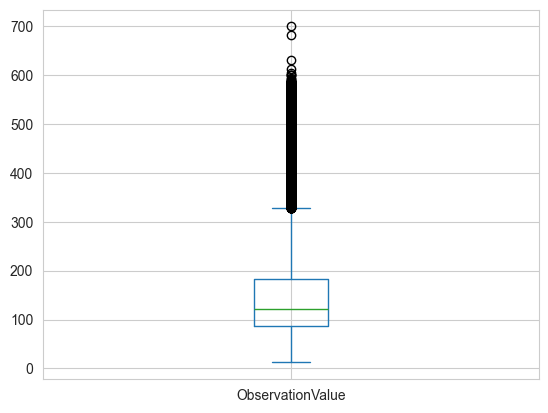

In [114]:
pao2_2012_2015_data['ObservationValue'].plot.box()

In [115]:
pao2_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_PaO2.csv')
pao2_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm
0,3,1/1/16 2:43,"pO2, ART",1,2:48:00 AM,295,1/1/16 2:48
1,3,1/1/16 2:43,"pO2, ART",1,7:29:00 AM,357,1/1/16 7:29
2,3,1/1/16 2:43,"pO2, ART",1,12:10:00 PM,124,1/1/16 12:10
3,3,1/1/16 2:43,"pO2, ART",3,11:20:00 AM,92,1/3/16 11:20
4,3,1/1/16 2:43,"pO2, ART",3,2:20:00 PM,94,1/3/16 14:20


In [116]:
pao2_2016_2019_data.dtypes

StudyID              int64
AdmitDtTm           object
Observation         object
DAY                  int64
TIME                object
ObservationValue     int64
ObservationDtTm     object
dtype: object

<Axes: >

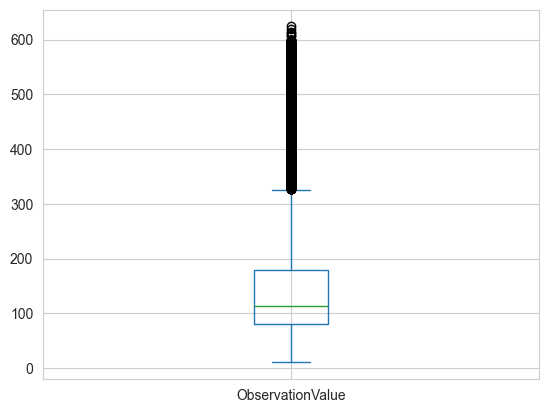

In [117]:
pao2_2016_2019_data['ObservationValue'].plot.box()

count    79976.000000
mean       153.306054
std        104.886440
min         10.000000
25%         83.000000
50%        117.000000
75%        181.000000
max        700.000000
Name: ObservationValue, dtype: float64


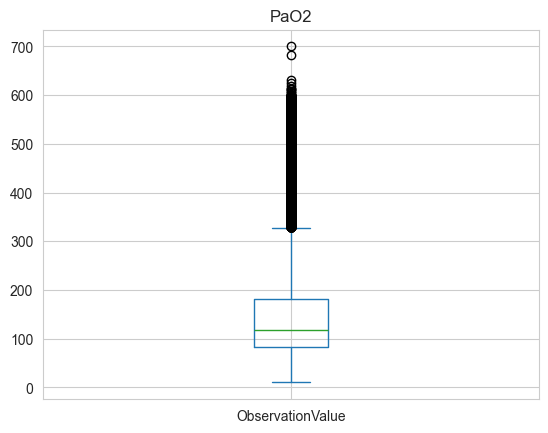

In [118]:
t = pd.concat([pao2_2016_2019_data['ObservationValue'], pao2_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('PaO2')
del t

The distributions for PaO2 are similar between 2012-2015 and 2016-2019. Units are mm Hg.

# PaCO2

In [119]:
paco2_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_PaCO2.csv')
paco2_2012_2015_data.head()

,StudyID,Observation,ObservationValue,Units,ObservationId,ObservationDtTm
0,16000,"pCO2, ART",40,mm Hg,PCO2,1/1/12 5:34 AM
1,16000,"pCO2, ART",44,mm Hg,PCO2,1/1/12 6:35 AM
2,16001,"pCO2, ART",29,mm Hg,PCO2,1/1/12 4:40 AM
3,16001,"pCO2, ART",32,mm Hg,PCO2,1/1/12 4:41 AM
4,16001,"pCO2, ART",27,mm Hg,PCO2,1/1/12 5:03 AM


In [120]:
paco2_2012_2015_data.dtypes

StudyID              int64
Observation         object
ObservationValue     int64
Units               object
ObservationId       object
ObservationDtTm     object
dtype: object

In [121]:
paco2_2012_2015_data['Units'].value_counts()

Units
mm Hg    38978
Name: count, dtype: int64

<Axes: >

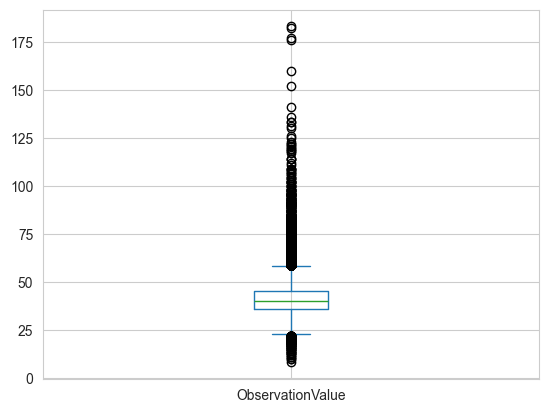

In [122]:
paco2_2012_2015_data['ObservationValue'].plot.box()

In [123]:
paco2_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_PaCO2.csv')
paco2_2016_2019_data.head()

,StudyID,AdmitDtTm,Observation,DAY,TIME,ObservationValue,ObservationDtTm,Unnamed: 7,Unnamed: 8
0,3,1/1/16 2:43 AM,"pCO2, ART",1,2:48:00 AM,34,1/1/16 2:48 AM,NaN,NaN
1,3,1/1/16 2:43 AM,"pCO2, ART",1,7:29:00 AM,36,1/1/16 7:29 AM,NaN,NaN
2,3,1/1/16 2:43 AM,"pCO2, ART",1,12:10:00 PM,35,1/1/16 12:10 PM,NaN,NaN
3,3,1/1/16 2:43 AM,"pCO2, ART",3,11:20:00 AM,35,1/3/16 11:20 AM,NaN,NaN
4,3,1/1/16 2:43 AM,"pCO2, ART",3,2:20:00 PM,32,1/3/16 2:20 PM,NaN,NaN


In [124]:
paco2_2016_2019_data.dtypes

StudyID               int64
AdmitDtTm            object
Observation          object
DAY                   int64
TIME                 object
ObservationValue      int64
ObservationDtTm      object
Unnamed: 7          float64
Unnamed: 8          float64
dtype: object

<Axes: >

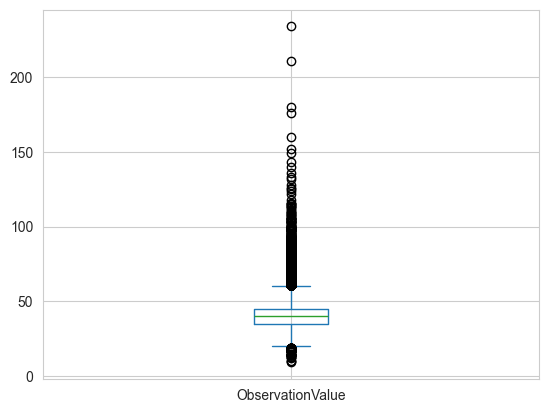

In [125]:
paco2_2016_2019_data['ObservationValue'].plot.box()

count    80040.000000
mean        41.271989
std          9.428703
min          8.000000
25%         36.000000
50%         40.000000
75%         45.000000
max        234.000000
Name: ObservationValue, dtype: float64


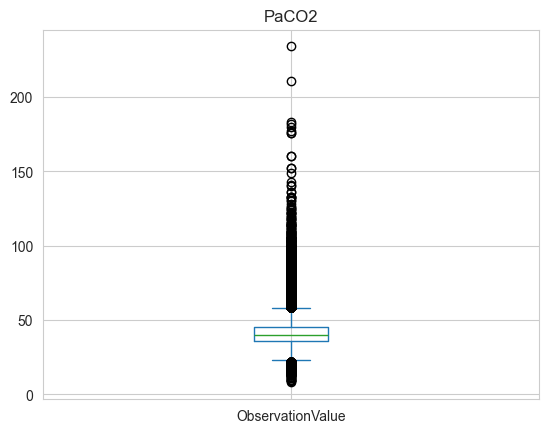

In [126]:
t = pd.concat([paco2_2016_2019_data['ObservationValue'], paco2_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('PaCO2')
del t

Distributions for PaCO2 are similar between 2012-2015 and 2016-2019. Units are mm Hg.

# SpO2

In [127]:
spo2_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_SpO2.csv')
spo2_2012_2015_data.head()

,STUDYID,DAY,TIME,RESULT_VAL,EVENT_CD_DESCR
0,16000,1,6:42:00 AM,100,SpO2
1,16000,1,7:00:00 AM,100,SpO2
2,16000,1,7:48:00 AM,99,SpO2
3,16000,1,8:11:00 AM,99,SpO2
4,16000,1,10:22:00 AM,100,SpO2


In [128]:
spo2_2012_2015_data.dtypes

STUDYID            int64
DAY                int64
TIME              object
RESULT_VAL        object
EVENT_CD_DESCR    object
dtype: object

In [129]:
spo2_2012_2015_data['RESULT_VAL'].unique()

array(['100', '99', 'SpO2 >= 92% on oxygen (1)', '96', '94', '95', '97',
       '98', '85', '89', '92', '91', '93', '40',
       'SpO2 >= 92% on room air (2)', '86', '88', '90', '84', '78', '83',
       '77', 'SpO2 < 92% on oxygen (0)', '79', '70', '64', '71', '68',
       '72', '87', '52', '80', '76', '74', '44', '33', '61', '50', '57',
       '66', '63', '82', '36', '81', '30', '75', '69', nan, '60', '58',
       '31', ' ', '62', '32', '0', '39', '55', '73', '49', '35', '34',
       '45', '59', '42', '46', '65', '56', '47', '38', '67', '22', '24',
       '54', '48', '51', '8', '37', '21', '43', '9', '10', '2', '53',
       '41', '7', '4', '16', '5', '18', '14', '1'], dtype=object)

In [130]:
spo2_2012_2015_data['RESULT_VAL'] = pd.to_numeric(spo2_2012_2015_data['RESULT_VAL'], errors='coerce')

<Axes: >

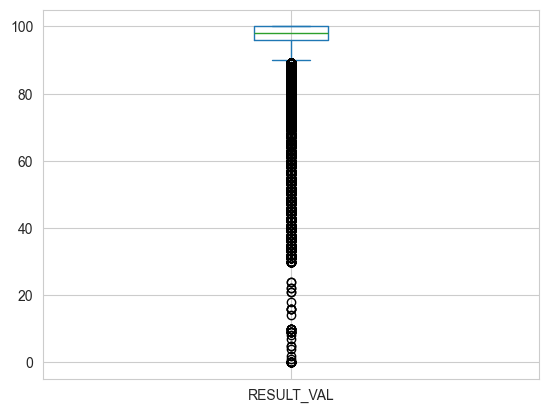

In [131]:
spo2_2012_2015_data['RESULT_VAL'].plot.box()

In [132]:
spo2_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_SpO2.csv')
spo2_2016_2019_data.rename(columns={'SpO2': 'RESULT_VAL'}, inplace=True)
spo2_2016_2019_data.drop(columns=['EVENT_END_DT_TM'], inplace=True)
spo2_2016_2019_data.head()

,STUDYID,DAY,TIME,RESULT_VAL
0,1,1,2:12:00 AM,97
1,2,1,2:18:00 AM,99
2,3,1,4:40:00 AM,99
3,4,1,5:55:00 AM,99
4,5,1,6:12:00 AM,97


In [133]:
spo2_2016_2019_data.dtypes

STUDYID        int64
DAY            int64
TIME          object
RESULT_VAL    object
dtype: object

In [134]:
spo2_2016_2019_data['RESULT_VAL'].unique()

array(['97', '99', '98', '100', 'SpO2 >= 92% on oxygen (1)', '96', '94',
       '95', '88', '92', '91', '93', '90', '83', '86', '77', '89', '85',
       '84', '87', '64', '74', '60', '79', 'SpO2 < 92% on oxygen (0)',
       '78', '80', '70', '46', '55', '58', '62', '73', '67', '59', '76',
       '53', 'SpO2 >= 92% on room air (2)', '82', '75', '81', nan, '42',
       '47', '54', '66', '63', '57', '69', '41', '38', '52', '0', '48',
       '34', '49', '72', '61', '65', '56', '40', '68', '50', '51', '43',
       '9', '31', '36', '#NAME?', '45', '30', '37', '71', '18', '2', '44',
       '10', '12', '32', '33', '35', '39', '14', '16', '17', '26', '28',
       '22', '1', '20', '15', '25', '3'], dtype=object)

In [135]:
spo2_2016_2019_data['RESULT_VAL'] = pd.to_numeric(spo2_2016_2019_data['RESULT_VAL'], errors='coerce')

<Axes: >

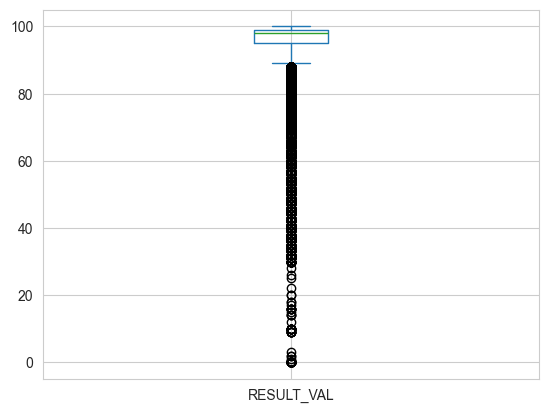

In [136]:
spo2_2016_2019_data['RESULT_VAL'].plot.box()

49743
count    2.133470e+06
mean     9.712218e+01
std      3.281972e+00
min      0.000000e+00
25%      9.600000e+01
50%      9.800000e+01
75%      1.000000e+02
max      1.000000e+02
Name: RESULT_VAL, dtype: float64


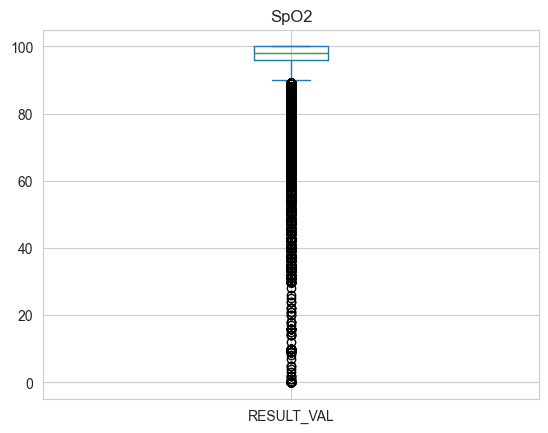

In [137]:
t = pd.concat([spo2_2016_2019_data['RESULT_VAL'], spo2_2012_2015_data['RESULT_VAL']])
print(t.isna().sum())
print(t.describe())
ax = t.plot.box()
ax.set_title('SpO2')
del t

Distributions look similar.

# HCO3

In [192]:
hco3_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_HCO3.csv')
hco3_2012_2015_data['Value'] = pd.to_numeric(hco3_2012_2015_data['Value'], errors='coerce')
hco3_2012_2015_data.head(50)

,STUDYID,Observation,DAY,TIME,Value,ObservationId
0,16000,"Bicarbonate, WBLD",1,05:38:00.0000000,17.0,HCO3
1,16000,"Bicarbonate, WBLD",1,06:45:00.0000000,22.0,HCO3
2,16001,"Bicarbonate, WBLD",1,04:53:00.0000000,16.0,HCO3
3,16001,"Bicarbonate, WBLD",1,04:54:00.0000000,17.0,HCO3
4,16001,"Bicarbonate, WBLD",1,05:08:00.0000000,16.0,HCO3
5,16001,"Bicarbonate, WBLD",1,05:51:00.0000000,15.0,HCO3
6,16001,"Bicarbonate, WBLD",1,08:01:00.0000000,21.0,HCO3
7,16001,"Bicarbonate, WBLD",1,11:53:00.0000000,25.0,HCO3
8,16001,"Bicarbonate, WBLD",1,15:22:00.0000000,25.0,HCO3
9,16001,"Bicarbonate, WBLD",1,20:41:00.0000000,25.0,HCO3


In [179]:
hco3_2012_2015_data.dtypes

STUDYID            int64
Observation       object
DAY                int64
TIME              object
Value            float64
ObservationId     object
dtype: object

In [138]:
hco3_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_HCO3.csv')
hco3_2016_2019_data.head()

,STUDYID,AdmitDtTm,Observation,DAY,TIME,Value,ObservationDtTm
0,3.0,1/1/16 2:43 AM,"Bicarbonate, WBLD",1,2:48:00 AM,18,1/1/16 2:48 AM
1,8.0,1/1/16 2:43 AM,"Bicarbonate, WBLD",1,7:29:00 AM,21,1/1/16 7:29 AM
2,9.0,1/1/16 2:43 AM,"Bicarbonate, WBLD",1,12:10:00 PM,24,1/1/16 12:10 PM
3,11.0,1/1/16 2:43 AM,"Bicarbonate, WBLD",3,11:20:00 AM,22,1/3/16 11:20 AM
4,12.0,1/1/16 2:43 AM,"Bicarbonate, WBLD",3,2:20:00 PM,20,1/3/16 2:20 PM


In [139]:
hco3_2016_2019_data.dtypes

STUDYID            float64
AdmitDtTm           object
Observation         object
DAY                  int64
TIME                object
Value                int64
ObservationDtTm     object
dtype: object

count    80005.000000
mean        24.038323
std          4.708383
min          2.000000
25%         21.000000
50%         24.000000
75%         27.000000
max         57.000000
Name: Value, dtype: float64


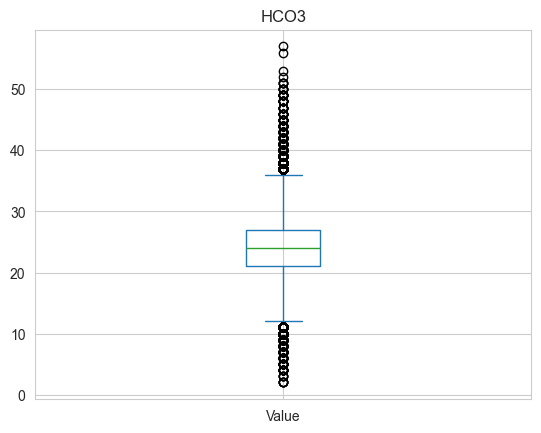

In [180]:
t = pd.concat([hco3_2016_2019_data['Value'], hco3_2012_2015_data['Value']])
print(t.describe())
ax = t.plot.box()
ax.set_title('HCO3')
del t

Only have 2016-2019 data.

# HGB

In [142]:
hgb_2012_2015_data = pd.read_csv('<path_to_dataset>/MASTER_2012-2015_hgb.csv')
hgb_2012_2015_data.head()

,STUDYID,Observation,ObservationValue,ObservationId,ObservationDtTm
0,16000,Hemoglobin,15.0,HB,1/1/12 5:13 AM
1,16000,Hemoglobin,10.7,HB,1/1/12 6:35 AM
2,16000,Hemoglobin,10.0,HB,1/1/12 4:10 PM
3,16000,Hemoglobin,9.9,HB,1/3/12 12:30 PM
4,16000,Hemoglobin,11.4,HB,1/4/12 6:30 AM


In [143]:
hgb_2012_2015_data.dtypes

STUDYID               int64
Observation          object
ObservationValue    float64
ObservationId        object
ObservationDtTm      object
dtype: object

<Axes: >

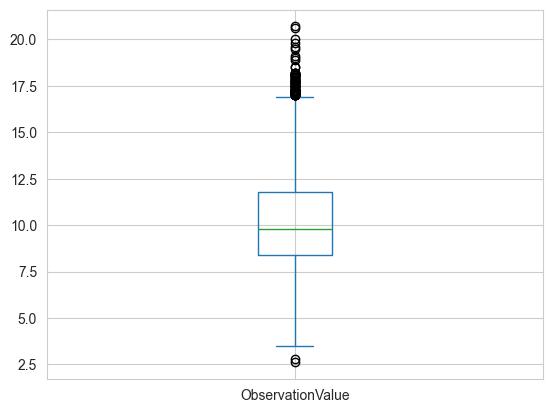

In [144]:
hgb_2012_2015_data['ObservationValue'].plot.box()

In [145]:
hgb_2016_2019_data = pd.read_csv('<path_to_dataset>/MASTER_2016-2019_hgb.csv')
hgb_2016_2019_data.head()

,STUDYID,Observation,DAY,TIME,Value,ObservationDtTm
0,3,Hemoglobin A1C by HPLC,9,3:23:00 AM,6.2,1/9/16 3:23 AM
1,8,Hemoglobin A1C by HPLC,13,2:20:00 AM,5.5,1/13/16 2:20 AM
2,10,Hemoglobin A1C by HPLC,2,3:05:00 AM,9.3,1/3/16 3:05 AM
3,13,Hemoglobin A1C by HPLC,2,4:13:00 AM,5.9,1/3/16 4:13 AM
4,15,Hemoglobin A1C by HPLC,2,9:25:00 AM,5.6,1/4/16 9:25 AM


In [146]:
hgb_2016_2019_data.dtypes

STUDYID              int64
Observation         object
DAY                  int64
TIME                object
Value              float64
ObservationDtTm     object
dtype: object

<Axes: >

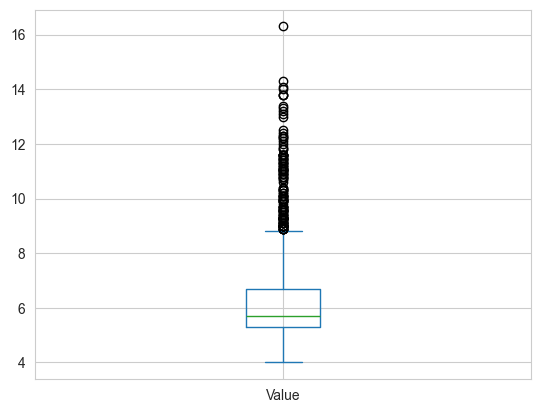

In [147]:
hgb_2016_2019_data['Value'].plot.box()

count    72904.000000
mean        10.042567
std          2.324624
min          2.600000
25%          8.300000
50%          9.700000
75%         11.700000
max         20.700000
dtype: float64


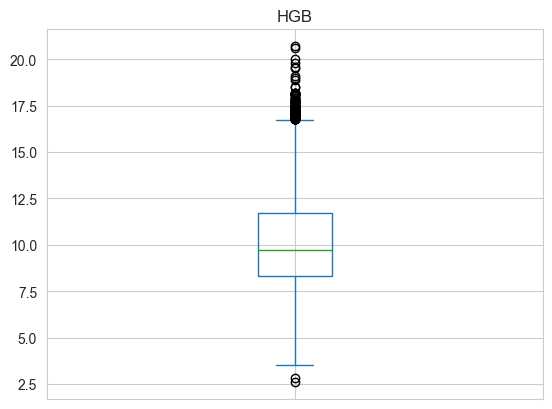

In [148]:
t = pd.concat([hgb_2016_2019_data['Value'], hgb_2012_2015_data['ObservationValue']])
print(t.describe())
ax = t.plot.box()
ax.set_title('HGB')
del t



# How many patients have all labs and vitals?

In [149]:
study_ids = load_patient_cohort_ids()

/var/folders/vf/695131157rl2pvb9_s5zykbh0000gn/T/ipykernel_8426/1824532707.py:18: DtypeWarning: Columns (1,2,133) have mixed types. Specify dtype option on import or set low_memory=False.
  compiled_patient_data_2012_2015 = pd.read_csv('/Users/larry/Documents/UWT/Thesis Work/rec_sys/datasets/trauma_icu_resuscitation/2012-2015_compiled_patient_data_with_cohorts_no_L_required_new_IVF_EarlyLateBolus.csv')


Number of patient cohort ids: 9437 (2012-2015: 4484, 2016-2019: 4953)


In [187]:
creatinine_patients = set(creatinine_2012_2015_data['StudyID']).union(set(creatinine_2016_2019_data['StudyID'])).intersection(study_ids)
inr_patients = set(inr_2012_2015_data['StudyID']).union(set(inr_2016_2019_data['StudyID'])).intersection(study_ids)
ph_patients = set(ph_2012_2015_data['StudyID']).union(set(ph_2016_2019_data['StudyID'])).intersection(study_ids)
fio2_patients = set(fio2_2012_2015_data['StudyID']).union(set(fio2_2016_2019_data['StudyID'])).intersection(study_ids)
fio2_corrected_patients = set(fio2_corrected_2012_2015_data['StudyID']).union(set(fio2_corrected_2016_2019_data['StudyID'])).intersection(study_ids)
rr_patients = set(rr_2016_2019_data['StudyID']).union(set(rr_2012_2015_data['STUDYID'])).intersection(study_ids)
map_patients = set(map_2012_2015_data['StudyID']).union(set(map_2016_2019_data['StudyID'])).intersection(study_ids)
hr_patients = set(hr_2012_2015_data['StudyID']).union(set(hr_2016_2019_data['StudyID'])).intersection(study_ids)
sbp_patients = set(sbp_2012_2015_data['StudyID']).union(set(sbp_2016_2019_data['StudyID'])).intersection(study_ids)
dbp_patients = set(dbp_2012_2015_data['StudyID']).union(set(dbp_2016_2019_data['StudyID'])).intersection(study_ids)
temp_patients = set(temp_2012_2015_data['StudyID']).union(set(temp_2016_2019_data['StudyID'])).intersection(study_ids)
uop_patients = set(uop_2012_2015_data['StudyID']).union(set(uop_2016_2019_data['StudyID'])).intersection(study_ids)
lactate_patients = set(lactate_2012_2015_data['StudyID']).union(set(lactate_2016_2019_data['StudyID'])).intersection(study_ids)
pao2_patients = set(pao2_2012_2015_data['StudyID']).union(set(pao2_2016_2019_data['StudyID'])).intersection(study_ids)
paco2_patients = set(paco2_2012_2015_data['StudyID']).union(set(paco2_2016_2019_data['StudyID'])).intersection(study_ids)
spo2_patients = set(spo2_2012_2015_data['STUDYID']).union(set(spo2_2016_2019_data['STUDYID'])).intersection(study_ids)
hco3_patients = set(hco3_2016_2019_data['STUDYID']).union(set(hco3_2012_2015_data['STUDYID'])).intersection(study_ids) # missing 2012-2015 data
hgb_patients = set(hgb_2012_2015_data['STUDYID']).union(set(hgb_2016_2019_data['STUDYID'])).intersection(study_ids)

print(f'Number of patients in cohort with creatinine: {len(creatinine_patients)}')
print(f'Number of patients in cohort with INR: {len(inr_patients)}')
print(f'Number of patients in cohort with pH: {len(ph_patients)}')
print(f'Number of patients in cohort with FiO2: {len(fio2_patients)}')
print(f'Number of patients in cohort with Corrected FiO2: {len(fio2_corrected_patients)}')
print(f'Number of patients in cohort with RR: {len(rr_patients)}')
print(f'Number of patients in cohort with MAP: {len(map_patients)}')
print(f'Number of patients in cohort with HR: {len(hr_patients)}')
print(f'Number of patients in cohort with SBP: {len(sbp_patients)}')
print(f'Number of patients in cohort with DBP: {len(dbp_patients)}')
print(f'Number of patients in cohort with Temp: {len(temp_patients)}')
print(f'Number of patients in cohort with UOP: {len(uop_patients)}')
print(f'Number of patients in cohort with lactate: {len(lactate_patients)}')
print(f'Number of patients in cohort with PaO2: {len(pao2_patients)}')
print(f'Number of patients in cohort with PaCO2: {len(paco2_patients)}')
print(f'Number of patients in cohort with SpO2: {len(spo2_patients)}')
print(f'Number of patients in cohort with HCO3: {len(hco3_patients)}')
print(f'Number of patients in cohort with HGB: {len(hgb_patients)}')

Number of patients in cohort with creatinine: 9434
Number of patients in cohort with INR: 9390
Number of patients in cohort with pH: 7048
Number of patients in cohort with FiO2: 5056
Number of patients in cohort with Corrected FiO2: 5056
Number of patients in cohort with RR: 9436
Number of patients in cohort with MAP: 9435
Number of patients in cohort with HR: 8883
Number of patients in cohort with SBP: 9436
Number of patients in cohort with DBP: 9436
Number of patients in cohort with Temp: 9436
Number of patients in cohort with UOP: 5583
Number of patients in cohort with lactate: 7157
Number of patients in cohort with PaO2: 7048
Number of patients in cohort with PaCO2: 7048
Number of patients in cohort with SpO2: 9435
Number of patients in cohort with HCO3: 7057
Number of patients in cohort with HGB: 5631


In [151]:
# cross ref arterial blood gas samples
pao2_patients_2016 = set(set(pao2_2016_2019_data['StudyID']).intersection(study_ids))
paco2_patients_2016 = set(set(paco2_2016_2019_data['StudyID']).intersection(study_ids))
print(f'Number of patients in cohort with PaO2 (2016-2019): {len(pao2_patients_2016)}')
print(f'Number of patients in cohort with PaCO2 (2016-2019): {len(paco2_patients_2016)}')
print(f'Number of patients in cohort with HCO3: {len(hco3_patients)}')

Number of patients in cohort with PaO2 (2016-2019): 3715
Number of patients in cohort with PaCO2 (2016-2019): 3715
Number of patients in cohort with HCO3: 3715


In [152]:
len(study_ids)

9437

In [153]:
print('Matching patient ids for HCO3, PaO2, and PaCO2:', hco3_patients == paco2_patients_2016 == pao2_patients_2016)
print('Matching patient ids for PaO2 and PaCO2:', paco2_patients_2016 == pao2_patients_2016)
print('Matching patient ids for HCO3 and PaCO2:', hco3_patients == paco2_patients_2016)
print('Matching patient ids for HCO3 and PaO2:', hco3_patients == pao2_patients_2016)
print('Number of patients in cohort with HCO3 and PaO2:', len(hco3_patients.intersection(pao2_patients_2016)))

Matching patient ids for HCO3, PaO2, and PaCO2: False
Matching patient ids for PaO2 and PaCO2: False
Matching patient ids for HCO3 and PaCO2: True
Matching patient ids for HCO3 and PaO2: False
Number of patients in cohort with HCO3 and PaO2: 3714


In [154]:
for pid in pao2_patients_2016:
    if not isinstance(pid, int):
        print(pid, type(pid))
    if pid is None:
        print('None pid')

In [155]:
for pid in paco2_patients_2016:
    if not isinstance(pid, int):
        print(pid, type(pid))
    if pid is None:
        print('None pid')

In [156]:
# union all labs and vitals
all_patients_og_fio2 = creatinine_patients.intersection(inr_patients).intersection(ph_patients).intersection(fio2_patients).intersection(map_patients).intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(uop_patients).intersection(lactate_patients).intersection(dbp_patients).intersection(pao2_patients).intersection(paco2_patients)
all_patients_corrected_fio2 = creatinine_patients.intersection(inr_patients).intersection(ph_patients).intersection(fio2_corrected_patients).intersection(map_patients).intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(uop_patients).intersection(lactate_patients).intersection(dbp_patients).intersection(pao2_patients).intersection(paco2_patients)

print(f'Number of patients with all labs and vitals (FiO2): {len(all_patients_og_fio2)}')
print(f'Number of patients with all labs and vitals (Corrected FiO2): {len(all_patients_corrected_fio2)}')

Number of patients with all labs and vitals (FiO2): 2894
Number of patients with all labs and vitals (Corrected FiO2): 2894


We only have 2603 patients will all labs and vitals. 
Questions:
- Is data missing? 
- Must we revise our state space?
- Do we proceed with 2603 patients?

In [157]:
all_patients_no_fi02 = creatinine_patients.intersection(inr_patients).intersection(ph_patients).intersection(map_patients).intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(uop_patients).intersection(lactate_patients).intersection(dbp_patients).intersection(pao2_patients).intersection(paco2_patients)
print(f'Number of patients with all labs and vitals (No FiO2): {len(all_patients_no_fi02)}')

Number of patients with all labs and vitals (No FiO2): 3840


In [158]:
all_patients_no_uop = creatinine_patients.intersection(inr_patients).intersection(ph_patients).intersection(fio2_patients).intersection(map_patients).intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(lactate_patients).intersection(dbp_patients).intersection(pao2_patients).intersection(paco2_patients)
print(f'Number of patients with all labs and vitals (No UOP): {len(all_patients_no_uop)}')

Number of patients with all labs and vitals (No UOP): 4618


In [159]:
all_patients_no_fi02_uop = creatinine_patients.intersection(inr_patients).intersection(ph_patients).intersection(map_patients).intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(lactate_patients).intersection(dbp_patients).intersection(pao2_patients).intersection(paco2_patients)
print(f'Number of patients with all labs and vitals (No FiO2 and UOP): {len(all_patients_no_fi02_uop)}')

Number of patients with all labs and vitals (No FiO2 and UOP): 6387


In [160]:
all_patients_no_fi02_uop_lactate = creatinine_patients.intersection(inr_patients).intersection(ph_patients).intersection(map_patients).intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(dbp_patients).intersection(pao2_patients).intersection(paco2_patients)
print(f'Number of patients with all labs and vitals (No FiO2, UOP, and lactate): {len(all_patients_no_fi02_uop_lactate)}')

Number of patients with all labs and vitals (No FiO2, UOP, and lactate): 6635


In [161]:
all_patients_only_vitals_no_uop = map_patients.intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(dbp_patients)#.intersection(uop_patients)
print(f'Number of patients with only vitals - no uop: {len(all_patients_only_vitals_no_uop)}')

Number of patients with only vitals - no uop: 8882


In [162]:
all_patients_only_vitals_no_uop_dbp = map_patients.intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients)
print(f'Number of patients with only vitals - no uop or dbp: {len(all_patients_only_vitals_no_uop_dbp)}')

Number of patients with only vitals - no uop or dbp: 8882


In [163]:
all_patients_only_vitals_no_dbp = map_patients.intersection(hr_patients).intersection(sbp_patients).intersection(temp_patients).intersection(uop_patients)
print(f'Number of patients with only vitals - no dbp: {len(all_patients_only_vitals_no_dbp)}')

Number of patients with only vitals - no dbp: 5031
